# lmm.ipynb

Notebook to apply LMM to control for clade relationships in virus-infected strains when quantifying differential expression

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings

# Suppress *all* warnings globally
warnings.filterwarnings("ignore")


## Bird's-eye view of mycovirus-strain relationship

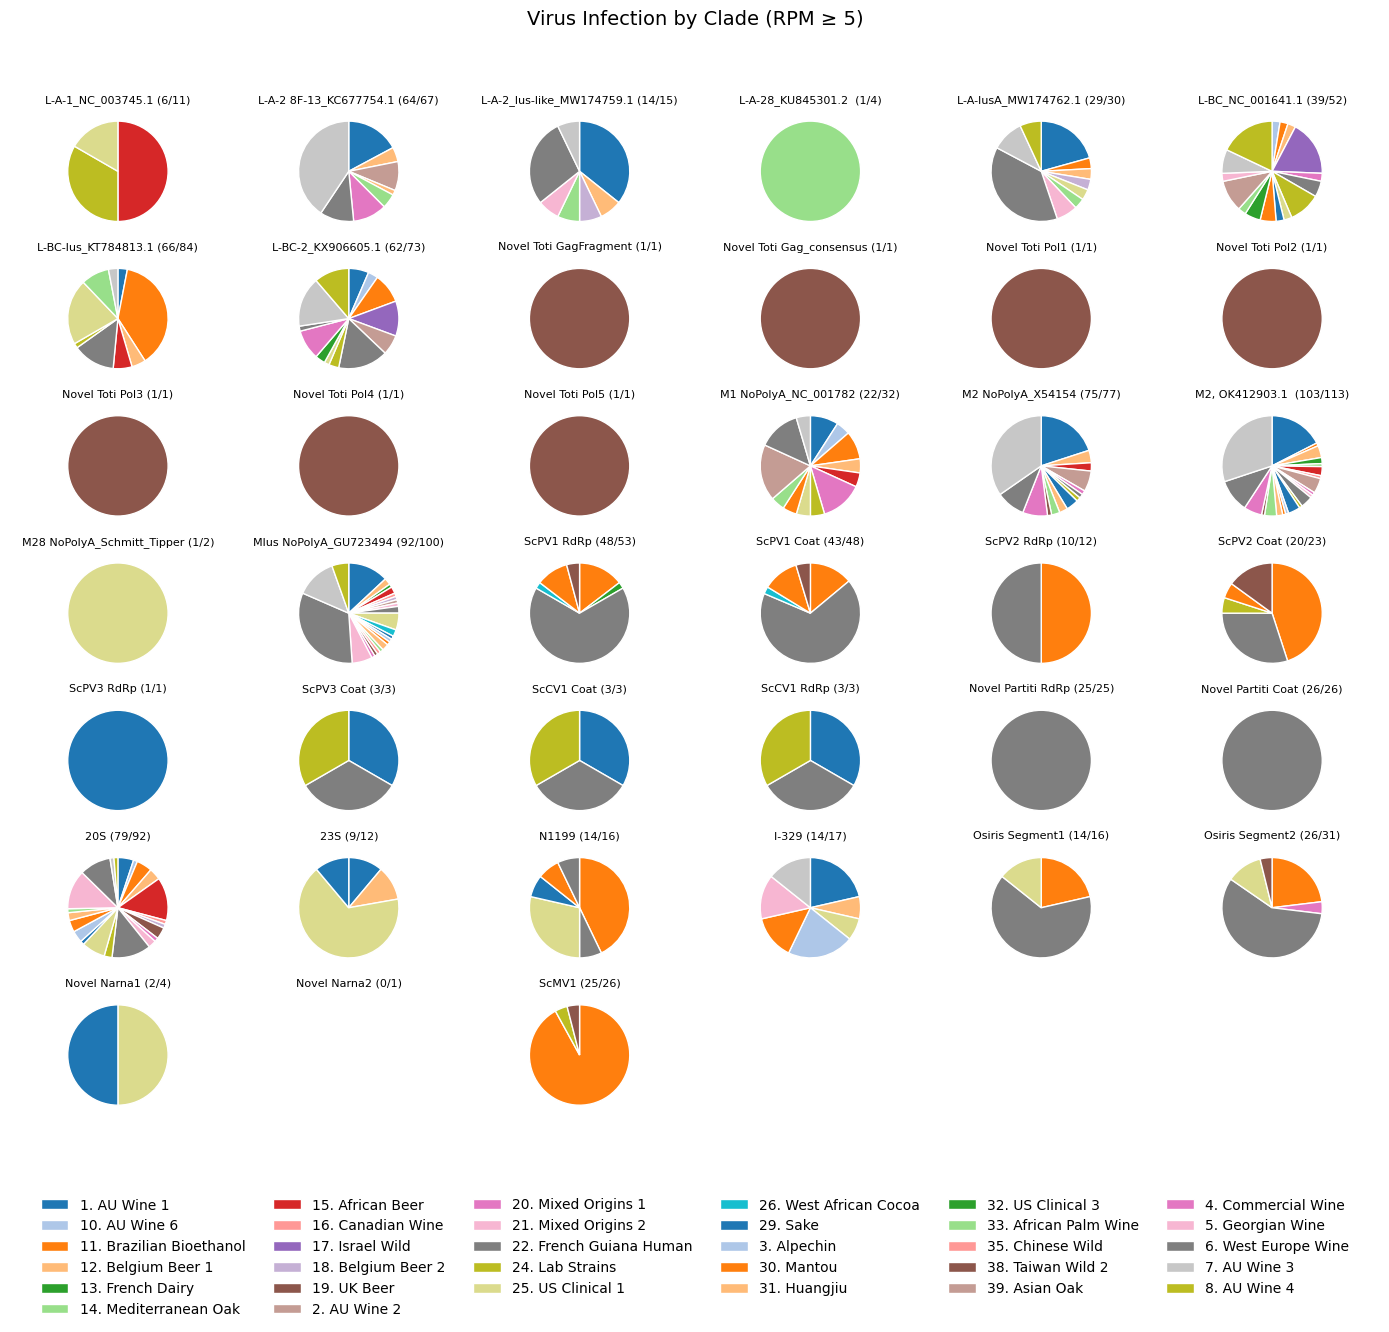

['L-A-1_NC_003745.1', 'L-A-2 8F-13_KC677754.1', 'L-A-2_lus-like_MW174759.1', 'L-A-28_KU845301.2 ', 'L-A-lusA_MW174762.1']


In [4]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from pathlib import Path
from matplotlib.patches import Patch


def plot_virus_infection_pies(
    virome_path="data/virome250531.tsv",
    clade_path="data/strain_ecodata.csv",
    map_path="data/rnaseq_accessions.tsv",
    min_rpm=5.0,  # i.e., minimum reads per million
    max_cols=6,
    figsize=(14, 12),
):
    """
    Plot per-virus pie charts showing clade composition of infected strains (RPM ≥ threshold).

    Returns list of virus names
    """

    # Load data
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    virome = pd.read_csv(virome_path, sep="\t", dtype=str)
    clade_df = pd.read_csv(clade_path)

    # Fix numeric conversion
    virome.iloc[:, 1:] = virome.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

    # Merge all metadata
    merged = virome.merge(mapper[["accession", "std_name"]], on="accession", how="inner")
    merged = merged.merge(
        clade_df[["std_name", "Clade"]].rename(columns={"Clade": "clade"}),
        on="std_name",
        how="left",
    )

    virus_cols = [col for col in merged.columns if col not in {"accession", "std_name", "clade"}]
    clades = sorted(merged["clade"].dropna().unique())
    cmap = get_cmap("tab20")
    clade_colors = {clade: cmap(i % 20) for i, clade in enumerate(clades)}

    # Track which clades are used (for legend)
    clades_used = set()

    # Layout
    n = len(virus_cols)
    ncols = min(n, max_cols)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()

    for i, virus in enumerate(virus_cols):
        df = merged[["std_name", "clade", virus]].copy()
        df["infected"] = df[virus] >= min_rpm
        infected = df[df["infected"]]

        # Count by clade
        clade_counts = infected["clade"].value_counts().sort_index()
        labels = clade_counts.index.tolist()
        sizes = clade_counts.values
        colors = [clade_colors.get(c, "gray") for c in labels]
        clades_used.update(labels)

        ax = axs[i]
        ax.pie(
            sizes,
            colors=colors,
            startangle=90,
            counterclock=False,
            wedgeprops={"edgecolor": "white"},
        )

        # Title: Virus (N_in_clade / N_total_infected)
        n_infected = len(infected)
        n_in_clade = clade_counts.sum()
        ax.set_title(f"{virus} ({n_in_clade}/{n_infected})", fontsize=8, pad=10)
        ax.axis("equal")

    # Clean up unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Legend: horizontal below the plot
    legend_elements = [
        Patch(facecolor=clade_colors[clade], edgecolor="white", label=clade)
        for clade in sorted(clades_used)
    ]

    fig.subplots_adjust(bottom=0.2)  # reserve space
    fig.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0),  # push completely outside
        ncol=6,
        fontsize=10,
        frameon=False,
    )

    fig.suptitle(f"Virus Infection by Clade (RPM ≥ {min_rpm})", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space at bottom for legend
    plt.show()

    return virus_cols


# === Call it
viruses = plot_virus_infection_pies(min_rpm=5)
print(viruses[:5])


## Load gene transcript counts data per strain (Caudal et al., 2024)

In [5]:
# Read transcript counts matrix
counts = pd.read_csv("data/count_matrix.csv.gz", index_col=0)
print(counts.shape)
print(counts.iloc[:5, :5])

(6454, 969)
                                AAA     AAB  AAD  AAE  AAG
systematic_name                                           
X1-EC1118_1F14_0012g            0.0    25.0  0.0  0.0  0.0
X10-EC1118_1F14_0133g           0.0  1368.0  0.0  0.0  0.0
X1003-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1004-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1005-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0


In [6]:
# Library size per strain (column)
lib_size = counts.sum(axis=0)
# Counts per million
cpm = counts.div(lib_size, axis=1) * 1e6
# Log2-transformed CPM + 1
logcpm = np.log2(cpm + 1)
logcpm.index.name = "gene"
logcpm.head()

,AAA,AAB,AAD,AAE,AAG,AAH,AAI,AAK,AAL,AAM,...,XTRA_DGX,XTRA_DGY,XTRA_DHB,XTRA_DHD,XTRA_DHE,XTRA_DHJ,XTRA_DHK,XTRA_DHO,XTRA_DHQ,XTRA_DXL
gene,,,,,,,,,,,,,,,,,,,,,
X1-EC1118_1F14_0012g,0.0,3.191946,0.0,0.0,0.0,3.994808,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10-EC1118_1F14_0133g,0.0,8.801982,0.0,0.0,0.0,4.213928,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1003-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1004-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1005-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Reshape to long format
long_df = logcpm.reset_index().melt(id_vars="gene", var_name="strain", value_name="logcpm")
long_df.head()

,gene,strain,logcpm
0,X1-EC1118_1F14_0012g,AAA,0.0
1,X10-EC1118_1F14_0133g,AAA,0.0
2,X1003-augustus_masked.YCM.7680,AAA,0.0
3,X1004-augustus_masked.YCM.7680,AAA,0.0
4,X1005-augustus_masked.YCM.7680,AAA,0.0


In [48]:
import pandas as pd
from pathlib import Path

def load_virome_infection_status(
    path_virome,
    virus,
    min_rpm=5.0,
    map_path="data/rnaseq_accessions.tsv",
    background="none",          # "none" or "rest"
    strict=False,               # NEW: require mono-infection by target virus set
    ignore_cols=("accession",),
):
    """
    Return sample-level labels for infection by a selected virus set.

    infected: 1 if passes selection (see strict), else 0
    background: 1 if in chosen background set, else 0
    co_count: number of OTHER viruses >= min_rpm
    other_any: 1 if any OTHER virus >= min_rpm, else 0
    """
    path_virome = Path(path_virome)
    map_path = Path(map_path)

    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    if "accession" not in mapper.columns or "std_name" not in mapper.columns:
        raise ValueError("Mapping file must contain 'accession' and 'std_name'.")

    df = pd.read_csv(path_virome, sep="\t", dtype=str)
    if "accession" not in df.columns:
        raise ValueError("Virome file must contain 'accession'.")

    # determine virus columns
    if isinstance(virus, str) and virus.upper() == "ANY":
        virus_cols = [c for c in df.columns if c not in ignore_cols]
    elif isinstance(virus, (list, tuple)):
        virus_cols = list(virus)
    else:
        virus_cols = [virus]

    all_virus_cols = [c for c in df.columns if c not in ignore_cols]

    # numeric
    df[all_virus_cols] = df[all_virus_cols].apply(pd.to_numeric, errors="coerce")

    # split into target vs other
    target = virus_cols
    other = [c for c in all_virus_cols if c not in set(target)]

    # calls
    target_any = (df[target] >= float(min_rpm)).any(axis=1) if target else pd.Series(False, index=df.index)
    other_any  = (df[other]  >= float(min_rpm)).any(axis=1) if other  else pd.Series(False, index=df.index)
    co_count   = (df[other]  >= float(min_rpm)).sum(axis=1) if other  else pd.Series(0, index=df.index)
    tot_count  = (df[all_virus_cols] >= float(min_rpm)).sum(axis=1)

    # strict rule
    if strict:
        if isinstance(virus, str) and virus.upper() == "ANY":
            # mono-infection by exactly one virus overall
            infected_mask = (tot_count == 1)
        else:
            # infected by target AND no other virus
            infected_mask = target_any & (~other_any)
    else:
        infected_mask = target_any

    # background
    if background == "none":
        background_mask = (~target_any) & (~other_any)  # completely clean
    elif background == "rest":
        background_mask = ~infected_mask                # all non-selected
    else:
        raise ValueError("background must be 'none' or 'rest'")

    out = pd.DataFrame({
        "accession": df["accession"],
        "infected": infected_mask.astype(int),
        "background": background_mask.astype(int),
        "co_count": co_count.astype(int),
        "other_any": other_any.astype(int),
        "tot_count": tot_count.astype(int),
    })

    out = out.merge(mapper[["accession","std_name"]], on="accession", how="inner")
    return out[["std_name","infected","background","co_count","other_any","tot_count"]]


def load_clade_mapping(path="data/strain_ecodata.csv"):
    df = pd.read_csv(path)
    if "std_name" not in df.columns or "Clade" not in df.columns:
        raise ValueError("strain_ecodata.csv must contain 'std_name' and 'Clade'.")
    return df[["std_name","Clade"]].rename(columns={"Clade":"clade"}).dropna()


def build_metadata(
    virome_path,
    virus,
    min_rpm=5.0,
    clade_path="data/strain_ecodata.csv",
    background="none",
    strict=False,
):
    lab = load_virome_infection_status(
        virome_path, virus, min_rpm=min_rpm, background=background, strict=strict
    )
    clades = load_clade_mapping(clade_path)
    meta = lab.merge(clades, on="std_name", how="inner")
    return meta[["std_name","infected","background","co_count","other_any","tot_count","clade"]]


def subset_for_contrast(meta: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only rows participating in the contrast: infected==1 OR background==1.
    """
    return meta.loc[(meta["infected"]==1) | (meta["background"]==1)].copy()


# Define virus of interest
# virus = "ScPV1 RdRp"
# virus = 'L-BC_NC_001641.1'
virus = "ANY"

# # 1. One virus vs uninfected only
meta = build_metadata("data/virome250531.tsv", virus=virus, background="none", min_rpm=5.0, strict=False)
# # 2. Group of viruses vs uninfected only
# meta = build_metadata("data/virome250531.tsv", virus=["N1199","N1210"], background="none")
# 3. Group of viruses vs the rest (others + uninfected)
# meta = build_metadata("data/virome250531.tsv", virus=["Osiris Segment1","Osiris Segment2"], background="none")
# 4. Any virus vs none
# meta = build_metadata("data/virome250531.tsv", virus="ANY", background="none")

print(f"Num infected: {sum(meta['infected'])}; num background: {sum(meta['background'])}")
meta.head()

Num infected: 393; num background: 485


,std_name,infected,background,co_count,other_any,tot_count,clade
0,AAB,1,0,0,0,1,12. Belgium Beer 1
1,AAD,1,0,0,0,2,29. Sake
2,AAE,0,1,0,0,0,5. Georgian Wine
3,AAI,0,1,0,0,0,1. AU Wine 1
4,AAK,1,0,0,0,1,5. Georgian Wine


In [9]:
d = build_metadata("data/virome250531.tsv", virus='Novel Toti Pol3', background="none", min_rpm=5.0, strict=False)
d[d['infected'] != 0]

,std_name,infected,background,co_count,other_any,tot_count,clade
618,CDA,1,0,9,1,10,38. Taiwan Wild 2


In [194]:
# # --- HACKY SPOOF: keep column names but flip meanings for "clade vs virus" analysis ---

# import pandas as pd
# import numpy as np

# def _compute_virus_state(virome_path, map_path, min_rpm=5.0, ignore_cols=("accession",), multi_label="multi"):
#     """
#     Returns ['std_name','virus_state'] where virus_state ∈ {'none', <virus_name>, multi}.
#     - If exactly one virus >= min_rpm → that virus name
#     - If none ≥ min_rpm → 'none'
#     - If ≥2 viruses ≥ min_rpm → 'multi'
#     """
#     v = pd.read_csv(virome_path, sep="\t", dtype=str)
#     if "accession" not in v.columns:
#         raise ValueError("Virome file must contain 'accession'.")
#     virus_cols = [c for c in v.columns if c not in ignore_cols]
#     v[virus_cols] = v[virus_cols].apply(pd.to_numeric, errors="coerce")

#     pres = (v[virus_cols] >= float(min_rpm))
#     k    = pres.sum(axis=1)

#     # pick the single positive virus where applicable
#     single = pres.idxmax(axis=1)
#     state = np.where(k == 0, "none", np.where(k == 1, single, multi_label)).astype(str)

#     mapper = pd.read_csv(map_path, sep="\t", dtype=str)
#     if {"accession","std_name"} - set(mapper.columns):
#         raise ValueError("Mapping file must contain 'accession' and 'std_name'.")

#     out = v[["accession"]].copy()
#     out["virus_state"] = state
#     out = out.merge(mapper[["accession","std_name"]], on="accession", how="inner")
#     return out[["std_name","virus_state"]]

# def spoof_meta_clade_vs_virus(
#     meta, *,
#     virome_path,
#     map_path="data/rnaseq_accessions.tsv",
#     target_clade,
#     min_rpm=5.0,
#     ignore_cols=("accession",),
#     include_none=True,          # keep 'none' as a virus class
#     drop_unknown=True           # drop strains with missing virus_state after merge
# ):
#     """
#     Hack: keep column names but reinterpret them:
#       - infected := 1 if clade == target_clade else 0
#       - clade    := virus_state ('none' | virus name | 'multi')
#       - background := 1 - infected  (simple complement for downstream filters)
#     """
#     vs = _compute_virus_state(virome_path, map_path, min_rpm=min_rpm, ignore_cols=ignore_cols)
#     m  = meta.merge(vs, on="std_name", how="left").copy()

#     if drop_unknown:
#         m = m[~m["virus_state"].isna()].copy()

#     if not include_none:
#         m = m[m["virus_state"] != "none"].copy()

#     # Spoof the meanings
#     m["infected"]   = (m["clade"] == target_clade).astype(int)
#     m["background"] = (1 - m["infected"]).astype(int)

#     # Overwrite 'clade' column with virus_state (so your downstream group='clade' == virus class)
#     m["clade"] = m["virus_state"].astype(str)
#     m = m.drop(columns=["virus_state"])

#     # Keep the same column set/order as your original meta where possible
#     cols = ["std_name","infected","background","co_count","other_any","tot_count","clade"]
#     for c in cols:
#         if c not in m.columns:
#             m[c] = np.nan
#     return m[cols]

# # ------------------------
# # Example usage:
# # ------------------------
# # You already built your original meta with build_metadata(...)
# # meta = build_metadata("data/virome250531.tsv", virus="L-BC_NC_001641.1", background="none", min_rpm=5.0, strict=False)

# target_clade = "22. French Guiana Human"   # <-- set the clade you want to be 'infected=1'
# meta = spoof_meta_clade_vs_virus(
#     meta,
#     virome_path="data/virome250531.tsv",
#     map_path="data/rnaseq_accessions.tsv",
#     target_clade=target_clade,
#     min_rpm=5.0,
#     include_none=True,   # treat non-infected as a virus class
# )

# print(meta.head())
# print("Counts -> infected=1:", int(meta["infected"].sum()),
#       " | infected=0:", int((1 - meta["infected"]).sum()),
#       " | virus classes:", meta["clade"].nunique())

# # Now you can reuse your existing pipeline as-is:
# # results = run_lmm_joblib(long_df, meta, predictor="infected", group="clade", n_jobs=16)
# # results.head()

In [52]:
# =============================
# Linear Mixed Model Pipeline — Hyper-optimized
# =============================

import os
import warnings
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.regression.mixed_linear_model import MixedLM

# ---- Optional: control BLAS threads (set these EARLY in your program, before NumPy imports) ----
# os.environ.setdefault("OMP_NUM_THREADS", "1")         # when using process-based parallelism
# os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
# os.environ.setdefault("MKL_NUM_THREADS", "1")
# os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# ---- Warnings: keep things quiet but safe ----
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*divide by zero.*", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*invalid value encountered.*", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*Random effects covariance is singular.*", category=UserWarning)


def _fit_slice(gene, start, stop, y, x, g_codes):
    """
    Hot path: fit MixedLM on a contiguous slice [start:stop) for a single gene.
    Returns (gene, beta, pval). Uses random-intercept per group.
    """
    ys = y[start:stop]
    xs = x[start:stop]
    gs = g_codes[start:stop]

    # Quick exits (constant predictor or single group)
    if xs.size < 2 or xs.min() == xs.max():
        return (gene, np.nan, np.nan)
    # unique groups needs to be >=2 for a random intercept model to make sense
    if np.min(gs) == np.max(gs):
        return (gene, np.nan, np.nan)

    # exog: [const, predictor]
    exog = np.empty((xs.shape[0], 2), dtype=np.float32)
    exog[:, 0] = 1.0
    exog[:, 1] = xs

    try:
        # LBFGS is typically fastest/most stable here
        fit = MixedLM(ys, exog, groups=gs).fit(reml=False, method="lbfgs", disp=False)
        # index 1 corresponds to predictor coefficient (exog[:,1])
        beta = float(fit.params[1]) if fit.params.shape[0] > 1 else np.nan
        pval = float(fit.pvalues[1]) if fit.pvalues.shape[0] > 1 else np.nan
        return (gene, beta, pval)
    except Exception:
        return (gene, np.nan, np.nan)


def run_lmm_joblib(
    long_df: pd.DataFrame,
    meta_df: pd.DataFrame,
    outcome: str = "logcpm",
    predictor: str = "infected",
    group: str = "clade",
    strain_col: str = "strain",
    meta_strain_col: str = "std_name",
    n_jobs: int = 8,
    backend: str = "threading",   # "threading" shares memory; try "loky" with MKL_NUM_THREADS=1 for heavy CPU boxes
    batch_size: int = 64,         # reduce scheduler overhead
    show_progress: bool = True,
) -> pd.DataFrame:
    """
    Run per-gene linear mixed models in parallel with minimal overhead.

    Returns:
        DataFrame with ['gene', 'beta', 'pval', 'fdr'].
    """
    # 1) Minimal, typed merge (only necessary columns), drop NA
    df = (
        long_df[["gene", strain_col, outcome]]
        .merge(
            meta_df[[meta_strain_col, predictor, group]],
            left_on=strain_col,
            right_on=meta_strain_col,
            how="inner",
            copy=False,
        )
        .loc[:, ["gene", outcome, predictor, group]]
        .dropna()
    )

    if df.empty:
        return pd.DataFrame(columns=["gene", "beta", "pval", "fdr"])

    # 2) Tight dtypes to lower memory bandwidth
    # predictor -> {0,1} float32; outcome -> float32; group -> categorical codes int32
    # Try to coerce booleans/ints to 0/1 smoothly
    pred_vals = df[predictor]
    if pred_vals.dtype == bool:
        df[predictor] = pred_vals.astype(np.float32, copy=False)
    elif np.issubdtype(pred_vals.dtype, np.number):
        # Normalize to 0/1 if it's not already
        unique_pred = pd.unique(pred_vals)
        if set(unique_pred) <= {0, 1}:
            df[predictor] = pred_vals.astype(np.float32, copy=False)
        else:
            # if it's numeric but not 0/1, treat nonzero as 1
            df[predictor] = (pred_vals != 0).astype(np.float32, copy=False)
    else:
        # assume string labels; map to 0/1 by first category
        df[predictor] = pd.Categorical(pred_vals).codes.astype(np.int8, copy=False)
        # remap {-1,0,1,...} -> 0/1 with a simple threshold
        df[predictor] = (df[predictor] > 0).astype(np.float32, copy=False)

    df[outcome] = df[outcome].astype(np.float32, copy=False)
    grp_cat = df[group].astype("category")
    g_codes = grp_cat.cat.codes.to_numpy(dtype=np.int32, copy=False)

    # 3) Sort once by gene and build contiguous slices (no small DataFrames)
    df.sort_values("gene", inplace=True, kind="mergesort")  # stable + cache-friendly
    genes_arr = df["gene"].to_numpy(copy=False)
    y = df[outcome].to_numpy(dtype=np.float32, copy=False)
    x = df[predictor].to_numpy(dtype=np.float32, copy=False)

    uniq_genes, first_idx, counts = np.unique(genes_arr, return_index=True, return_counts=True)
    starts = first_idx
    stops = first_idx + counts

    tasks = (delayed(_fit_slice)(g, s, e, y, x, g_codes)
             for g, s, e in zip(uniq_genes, starts, stops))

    if show_progress:
        tasks = tqdm(tasks, total=len(uniq_genes), desc="Running LMMs")

    results = Parallel(
        n_jobs=n_jobs,
        backend=backend,
        batch_size=batch_size,
        prefer="threads"
    )(tasks)

    # 5) Assemble + FDR (mask NaNs so multipletests isn’t confused)
    res_df = pd.DataFrame(results, columns=["gene", "beta", "pval"])
    mask = res_df["pval"].notna().to_numpy()
    fdr = np.full(res_df.shape[0], np.nan, dtype=np.float64)
    if mask.any():
        fdr[mask] = multipletests(res_df.loc[mask, "pval"].values, method="fdr_bh")[1]
    res_df["fdr"] = fdr
    return res_df


# Filter clades with fewer than N members
min_clade_members = 2
valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
meta = meta[meta["clade"].isin(valid_clades)]

results = run_lmm_joblib(long_df, meta, n_jobs=8, batch_size=512)
results.head()

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

,gene,beta,pval,fdr
0,X1-EC1118_1F14_0012g,NaN,NaN,NaN
1,X10-EC1118_1F14_0133g,NaN,NaN,NaN
2,X1003-augustus_masked.YCM.7680,NaN,NaN,NaN
3,X1004-augustus_masked.YCM.7680,NaN,NaN,NaN
4,X1005-augustus_masked.YCM.7680,NaN,NaN,NaN


In [66]:
# =====================================
# Permutation-aware LMM DEG Analysis
# =====================================
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import display
from statsmodels.stats.multitest import multipletests
from IPython.display import display, HTML

# Widen display for gene_desc and other columns
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

# --- Helper: Shuffle infection labels within each clade ---
def shuffle_infection_within_clades(meta: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    meta_shuffled = meta.copy()
    meta_shuffled["infected"] = (
        meta_shuffled.groupby("clade")["infected"]
        .transform(lambda x: rng.permutation(x.values))
    )
    return meta_shuffled

# --- Helper: Run permutation test ---
def run_permutation_lmm(long_df, meta_df, n=100, seed=42):
    null_dist = []

    for i in tqdm(range(n), desc="Running Permutation LMMs"):
        meta_shuff = shuffle_infection_within_clades(meta_df, seed=seed+i)
        res = run_lmm_joblib(long_df, meta_shuff, n_jobs=16)
        res["perm_id"] = i
        null_dist.append(res[["gene", "beta", "perm_id"]])

    return pd.concat(null_dist, ignore_index=True)

# --- Helper: Empirical p-value calculation ---
def compute_empirical_pvals(observed_df, null_df):
    observed = observed_df.copy()
    null_abs = null_df.copy()
    null_abs["abs_beta"] = null_abs["beta"].abs()
    
    # Precompute null distribution per gene
    null_lookup = null_abs.groupby("gene")["abs_beta"].apply(list).to_dict()

    empirical_pvals = []
    for _, row in observed.iterrows():
        gene = row["gene"]
        obs_val = abs(row["beta"])
        null_vals = null_lookup.get(gene, [])
        p_emp = (np.sum(np.array(null_vals) >= obs_val) + 1) / (len(null_vals) + 1)
        empirical_pvals.append(p_emp)

    observed["empirical_pval"] = empirical_pvals
    observed["empirical_fdr"] = multipletests(observed["empirical_pval"], method="fdr_bh")[1]
    return observed

# --- Helper: Summarize top DEGs ---
def get_top_degs(empirical_results: pd.DataFrame, fdr_cutoff=0.05, top_n=10_000):
    sig = empirical_results[empirical_results["empirical_fdr"] <= fdr_cutoff]
    up = sig[sig["beta"] > 0].sort_values("empirical_fdr").head(top_n)
    down = sig[sig["beta"] < 0].sort_values("empirical_fdr").head(top_n)
    return up, down

# =====================================
# Run Permutation LMM Pipeline
# =====================================
# n_perms = 1000
# perm_null = run_permutation_lmm(long_df, meta, n=n_perms)

# observed = run_lmm_joblib(long_df, meta, n_jobs=12, batch_size=512)
# empirical = compute_empirical_pvals(observed, perm_null)

# Show top DEGs
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

def open_json(filepath):
    with open(filepath, encoding="utf-8") as f:
        return json.load(f)
    
sys_gene_to_std_gene = open_json(SYS2STD)
sys_gene_to_desc = open_json(SYS2DESC)

top_up, top_down = get_top_degs(empirical, fdr_cutoff=0.1)
# Add a new column using .map()
top_up["std_gene"] = top_up["gene"].map(sys_gene_to_std_gene).fillna(top_up["gene"])
top_up["gene_desc"] = top_up["gene"].map(sys_gene_to_desc).fillna(top_up["gene"])
top_down["std_gene"] = top_down["gene"].map(sys_gene_to_std_gene).fillna(top_down["gene"])
top_down["gene_desc"] = top_down["gene"].map(sys_gene_to_desc).fillna(top_down["gene"])

# Now display with std_gene included
print(f"\nTop {len(top_up)} upregulated genes:")
display(
    top_up[["gene", "std_gene", 'gene_desc', "beta", "empirical_fdr"]]
    .sort_values("beta", ascending=False).head(40)
)

print(f"\nTop {len(top_down)} downregulated genes:")
display(top_down[["gene", "std_gene", 'gene_desc', "beta", "empirical_fdr"]]
        .sort_values("beta", ascending=True).head(40))

Running Permutation LMMs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]


Top 66 upregulated genes:


,gene,std_gene,gene_desc,beta,empirical_fdr
364,X979-augustus_masked.BCD_8.12448,X979-augustus_masked.BCD_8.12448,X979-augustus_masked.BCD_8.12448,0.445813,0.073976
193,X237-augustus_masked.4776.BCQ_8,X237-augustus_masked.4776.BCQ_8,X237-augustus_masked.4776.BCQ_8,0.395855,0.005357
1511,YDR218C,SPR28,Sporulation-specific homolog of the CDC3/10/11/12 family of genes; meiotic septin expressed at high levels during meiotic divisions and ascospore formation; the yeast CDC3/10/11/12 family is a family of bud neck microfilament genes,0.373180,0.031898
29,X1186-augustus_masked.CNI_4.19788,X1186-augustus_masked.CNI_4.19788,X1186-augustus_masked.CNI_4.19788,0.331570,0.014935
5865,YOR285W,RDL1,Thiosulfate sulfurtransferase; contains a rhodanese-like domain; localized to the mitochondrial outer membrane; protein abundance increases in response to DNA replication stress; similar to the human TSTD gene,0.295121,0.040304
751,YBR169C,SSE2,"Member of Hsp110 subclass of the heat shock protein 70 (HSP70) family; serves as nucleotide exchange factor to load ATP onto the SSA class of cytosolic Hsp70s; may be involved in protein folding; localized to the cytoplasm; SSE2 has a paralog, SSE1, that arose from the whole genome duplication",0.261112,0.009622
3722,YKL035W,UGP1,"UDP-glucose pyrophosphorylase (UGPase); catalyses the reversible formation of UDP-Glc from glucose 1-phosphate and UTP, involved in a wide variety of metabolic pathways, expression modulated by Pho85p through Pho4p; involved in PKA-mediated oxidative stress resistance and long-term survival in stationary phase; UGP1 has a paralog, YHL012W, that arose from the whole genome duplication",0.224645,0.009622
3878,YKL187C,FAT3,"Protein required for fatty acid uptake; protein abundance increases in cortical patches in response to oleate exposure; the authentic, non-tagged protein is detected in a phosphorylated state in highly purified mitochondria in high-throughput studies; FAT3 has a paralog, YLR413W, that arose from the whole genome duplication",0.212428,0.021314
967,YCR018C-A,YCR018C-A,Putative protein of unknown function; encoded opposite a Ty1 LTR,0.208745,0.009622
5769,YOR185C,GSP2,"GTP binding protein (mammalian Ranp homolog); involved in the maintenance of nuclear organization, RNA processing and transport; interacts with Kap121p, Kap123p and Pdr6p (karyophilin betas); not required for viability; protein abundance increases in response to DNA replication stress; GSP2 has a paralog, GSP1, that arose from the whole genome duplication",0.205366,0.026612



Top 53 downregulated genes:


,gene,std_gene,gene_desc,beta,empirical_fdr
446,YAR028W,KTD1,Putative integral membrane protein; member of DUP240 gene family; GFP-fusion protein is induced in response to the DNA-damaging agent MMS,-0.477125,0.009622
1086,YDL037C,BSC1,"Protein of unconfirmed function; similar to cell surface flocculin Flo11p; ORF exhibits genomic organization compatible with a translational readthrough-dependent mode of expression; in W303 strain one continuous open reading frame comprising of YDL037C, the intergenic region and YDL039C encodes the gene IMI1",-0.353591,0.010684
885,YBR301W,PAU24,"Cell wall mannoprotein; has similarity to Tir1p, Tir2p, Tir3p, and Tir4p; member of the seripauperin multigene family encoded mainly in subtelomeric regions; expressed under anaerobic conditions, completely repressed during aerobic growth",-0.325479,0.029781
6372,YPR123C,YPR123C,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data; partially/completely overlaps the verified ORF CTR",-0.294362,0.003220
3305,YIR034C,LYS1,"Saccharopine dehydrogenase (NAD+, L-lysine-forming); catalyzes the conversion of saccharopine to L-lysine, which is the final step in the lysine biosynthesis pathway; contains mRNA binding activity; required for targeting of Pls1p to the peroxisomal matrix in the absence of lysine",-0.226390,0.011750
506,YBL042C,FUI1,"High affinity uridine permease, localizes to the plasma membrane; also mediates low but significant transport of the cytotoxic nucleoside analog 5-fluorouridine; not involved in uracil transport; relative distribution to the vacuole increases upon DNA replication stress",-0.224534,0.001075
6066,YPL093W,NOG1,Putative GTPase; associates with free 60S ribosomal subunits in the nucleolus and is required for 60S ribosomal subunit biogenesis; constituent of 66S pre-ribosomal particles; member of the ODN family of nucleolar G-proteins,-0.192766,0.006425
2932,YHR066W,SSF1,"Constituent of 66S pre-ribosomal particles; required for ribosomal large subunit maturation; functionally redundant with Ssf2p; member of the Brix family; SSF1 has a paralog, SSF2, that arose from the whole genome duplication",-0.192732,0.005357
4250,YLR180W,SAM1,"S-adenosylmethionine synthetase; catalyzes transfer of the adenosyl group of ATP to the sulfur atom of methionine; SAM1 has a paralog, SAM2, that arose from the whole genome duplication",-0.187063,0.019192
4920,YMR239C,RNT1,"Nuclear dsRNA-specific ribonuclease (RNase III); involved in rDNA transcription, rRNA processing and U2 snRNA 3' end formation by cleavage of a stem-loop structure at the 3' end of U2 snRNA; involved in polyadenylation-independent transcription termination; involved in the cell wall stress response, regulating the degradation of cell wall integrity and morphogenesis checkpoint genes",-0.179609,0.003220


In [69]:
# Now display with std_gene included
print(f"\nTop {len(top_up)} upregulated genes:")
display(
    top_up[["gene", "std_gene", 'gene_desc', "beta", "empirical_fdr"]]
    # .sort_values("beta", ascending=False).head(40)
    .sort_values(["empirical_fdr", 'beta'], ascending=[True, False]).head(40)
)

print(f"\nTop {len(top_down)} downregulated genes:")
display(top_down[["gene", "std_gene", 'gene_desc', "beta", "empirical_fdr"]]
    # .sort_values("beta", ascending=True).head(40)
    .sort_values(["empirical_fdr", 'beta'], ascending=[True, True]).head(40)
   )


Top 66 upregulated genes:


,gene,std_gene,gene_desc,beta,empirical_fdr
357,X941-augustus_masked.BDG_5.19334,X941-augustus_masked.BDG_5.19334,X941-augustus_masked.BDG_5.19334,0.129711,0.001075
4496,YLR426W,TDA5,Putative protein of unknown function; detected in highly purified mitochondria in high-throughput studies; proposed to be involved in resistance to mechlorethamine and streptozotocin; null mutant sensitive to expression of top1-T722A allele,0.061859,0.002149
2754,YGR244C,LSC2,Beta subunit of succinyl-CoA ligase; succinyl-CoA ligase is a mitochondrial enzyme of the TCA cycle that catalyzes the nucleotide-dependent conversion of succinyl-CoA to succinate,0.099390,0.003220
3781,YKL091C,YKL091C,"Putative phosphatidylinositol/phosphatidylcholine transfer protein; possibly involved in lipid metabolism; localizes to the nucleus; contains a CRAL/TRIO domain and binds several lipids in a large-scale study; YKL091C has a paralog, SEC14, that arose from the whole genome duplication",0.131140,0.004288
6141,YPL170W,DAP1,"Heme-binding protein; involved in regulation of cytochrome P450 protein Erg11p; damage response protein, related to mammalian membrane progesterone receptors; mutations lead to defects in telomeres, mitochondria, and sterol synthesis",0.128197,0.004288
1794,YDR503C,LPP1,"Lipid phosphate phosphatase; catalyzes Mg(2+)-independent dephosphorylation of phosphatidic acid (PA), lysophosphatidic acid, and diacylglycerol pyrophosphate; involved in control of the cellular levels of phosphatidylinositol and PA",0.109923,0.004288
4101,YLR028C,ADE16,"Enzyme of 'de novo' purine biosynthesis; contains both 5-aminoimidazole-4-carboxamide ribonucleotide transformylase and inosine monophosphate cyclohydrolase activities; ADE16 has a paralog, ADE17, that arose from the whole genome duplication; ade16 ade17 mutants require adenine and histidine",0.055846,0.004288
193,X237-augustus_masked.4776.BCQ_8,X237-augustus_masked.4776.BCQ_8,X237-augustus_masked.4776.BCQ_8,0.395855,0.005357
870,YBR284W,YBR284W,"Putative metallo-dependent hydrolase superfamily protein; similar to AMP deaminases but lacks key catalytic residues and does not rescue purine nucleotide metabolic defect of quadruple aah1 ade8 amd1 his1 mutant; null mutant exhibits longer telomeres, altered Ty mobility, decreased resistance to rapamycin and wortmannin; induced in response to hydrostatic pressure; not an essential gene; YBR284W has a paralog, YJL070C, that arose from the whole genome duplication",0.156352,0.005357
692,YBR111W-A,SUS1,"Global transcriptional regulator, component of SAGA, TREX-2 complexes; interacts with RNA polymerase II; involved in mRNA export coupled transcription activation and elongation; involved in post-transcriptional tethering of active genes to nuclear periphery and to non-nascent mRNP; plays role in negatively regulating telomere length through modulation of H2BK123 mono-ubiquitination and its interaction with nuclear pore complex",0.063643,0.005357



Top 53 downregulated genes:


,gene,std_gene,gene_desc,beta,empirical_fdr
506,YBL042C,FUI1,"High affinity uridine permease, localizes to the plasma membrane; also mediates low but significant transport of the cytotoxic nucleoside analog 5-fluorouridine; not involved in uracil transport; relative distribution to the vacuole increases upon DNA replication stress",-0.224534,0.001075
5642,YOR056C,NOB1,"Protein involved in proteasomal and 40S ribosomal subunit biogenesis; required for cleavage of the 20S pre-rRNA to generate the mature 18S rRNA; cleavage is activated by Fun12p, a GTPase and translation initiation factor; relocalizes from nucleus to nucleolus upon DNA replication stress",-0.167379,0.001075
5791,YOR207C,RET1,"Second-largest subunit of RNA polymerase III; RNA polymerase III is responsible for the transcription of tRNA and 5S RNA genes, and other low molecular weight RNAs",-0.130194,0.001075
4049,YLL038C,ENT4,Protein of unknown function; contains an N-terminal epsin-like domain; proposed to be involved in the trafficking of Arn1p in the absence of ferrichrome,-0.127749,0.001075
5441,YOL021C,DIS3,"Exosome core complex catalytic subunit; has both endonuclease and 3'-5' exonuclease activity; involved in 3'-5' RNA processing and degradation in both the nucleus and the cytoplasm; role in degradation of tRNAs; similar to E. coli RNase R and to human DIS3, which partially complements dis3-81 heat sensitivity; mutations in Dis3p analogous to human mutations implicated in multiple myeloma impair exosome function; protein abundance increases under to DNA replication stress",-0.099328,0.001075
245,X477-maker.2859.CPI_4,X477-maker.2859.CPI_4,X477-maker.2859.CPI_4,-0.077435,0.001075
722,YBR141C,BMT2,Nucleolar S-adenosylmethionine-dependent rRNA methyltransferase; methylates adenine (m1A) of large subunit (LSU) rRNA at position 2142; belongs to Rossmann fold superfamily; null mutant exhibits abnormal lipid metabolic phenotype; not an essential gene,-0.171809,0.002149
5583,YOR001W,RRP6,"Nuclear exosome exonuclease component; has 3'-5' exonuclease activity that is regulated by Lrp1p; involved in RNA processing, maturation, surveillance, degradation, tethering, and export; role in sn/snoRNAs precursor degradation; forms a stable heterodimer with Lrp1p; has similarity to E. coli RNase D and to human PM-Sc1 100 (EXOSC10); mutant displays reduced transcription elongation in the G-less-based",-0.113093,0.002149
6372,YPR123C,YPR123C,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data; partially/completely overlaps the verified ORF CTR",-0.294362,0.003220
4920,YMR239C,RNT1,"Nuclear dsRNA-specific ribonuclease (RNase III); involved in rDNA transcription, rRNA processing and U2 snRNA 3' end formation by cleavage of a stem-loop structure at the 3' end of U2 snRNA; involved in polyadenylation-independent transcription termination; involved in the cell wall stress response, regulating the degradation of cell wall integrity and morphogenesis checkpoint genes",-0.179609,0.003220


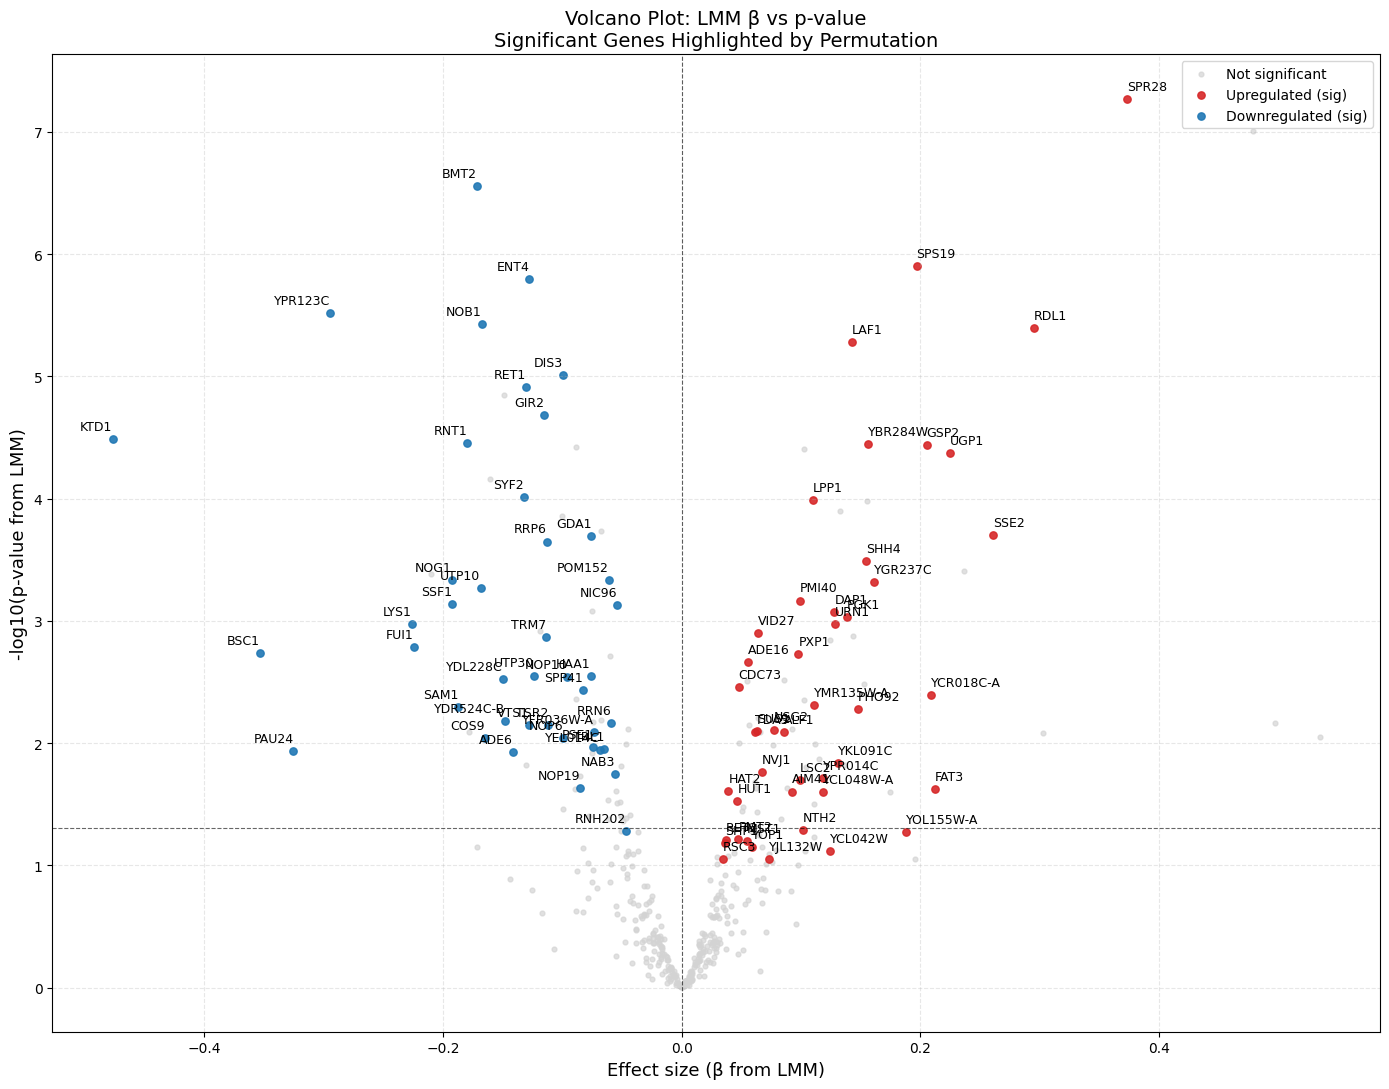

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_volcano_std_named(
    df,
    sys2std_map,
    beta_col="beta",
    pval_col="pval",
    fdr_col="empirical_fdr",
    gene_col="gene",
    top_up=None,
    top_down=None,
    fdr_thresh=0.25,
    beta_thresh=0.0,
    figsize=(14, 11),
    label_fontsize=9,
    title="Volcano Plot: LMM β vs p-value\nSignificant Genes Highlighted by Permutation",
    label_offset=0.05
):
    """
    Volcano plot using β vs –log10(p-value), labeling genes from sys2std_map only
    if they pass the FDR threshold and are in the top_up/top_down list.
    """
    df = df.copy()
    df["std_gene"] = df[gene_col].map(sys2std_map)
    df = df.dropna(subset=["std_gene"])  # Only keep mapped genes
    df["log10_pval"] = -np.log10(df[pval_col].clip(lower=1e-300))

    # Define significance masks
    sig_mask = df[fdr_col] <= fdr_thresh
    up_mask = (df[beta_col] >= beta_thresh) & sig_mask
    down_mask = (df[beta_col] <= -beta_thresh) & sig_mask
    nonsig_mask = ~sig_mask

    fig, ax = plt.subplots(figsize=figsize)

    # Plot points
    ax.scatter(df.loc[nonsig_mask, beta_col],
               df.loc[nonsig_mask, "log10_pval"],
               color="lightgray", s=12, alpha=0.7, label="Not significant")

    ax.scatter(df.loc[up_mask, beta_col],
               df.loc[up_mask, "log10_pval"],
               color="#d62728", s=28, alpha=0.9, label="Upregulated (sig)")

    ax.scatter(df.loc[down_mask, beta_col],
               df.loc[down_mask, "log10_pval"],
               color="#1f77b4", s=28, alpha=0.9, label="Downregulated (sig)")

    # Label top genes if provided
    if top_up is not None:
        for _, row in top_up.iterrows():
            gene = row[gene_col]
            if gene in sys2std_map:
                match = df[df[gene_col] == gene]
                if not match.empty and match.iloc[0][fdr_col] <= fdr_thresh:
                    beta = match.iloc[0][beta_col]
                    log10_pval = match.iloc[0]["log10_pval"]
                    ax.text(beta, log10_pval + label_offset,
                            sys2std_map[gene],
                            color="black", fontsize=label_fontsize,
                            ha="left", va="bottom")

    if top_down is not None:
        for _, row in top_down.iterrows():
            gene = row[gene_col]
            if gene in sys2std_map:
                match = df[df[gene_col] == gene]
                if not match.empty and match.iloc[0][fdr_col] <= fdr_thresh:
                    beta = match.iloc[0][beta_col]
                    log10_pval = match.iloc[0]["log10_pval"]
                    ax.text(beta, log10_pval + label_offset,
                            sys2std_map[gene],
                            color="black", fontsize=label_fontsize,
                            ha="right", va="bottom")

    # Formatting
    ax.axvline(0, linestyle="--", color="black", lw=0.8, alpha=0.6)
    ax.axhline(-np.log10(0.05), linestyle="--", color="black", lw=0.8, alpha=0.6)
    ax.set_xlabel("Effect size (β from LMM)", fontsize=13)
    ax.set_ylabel("-log10(p-value from LMM)", fontsize=13)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    
plot_volcano_std_named(
    df=empirical,
    sys2std_map=sys_gene_to_std_gene,
    top_up=top_up,
    top_down=top_down,
    fdr_thresh=0.05,
    beta_thresh=0.0,
)

In [84]:
1 / 2 ** 0.5

0.7071067811865475

In [53]:
import re
import pandas as pd


def filter_systematic_orfs(df, gene_col="gene"):
    """
    Keep only yeast systematic ORFs (e.g. YBR123C, YGL255W-A).

    Parameters
    ----------
    df : DataFrame
        Input DataFrame with a gene column.
    gene_col : str, default "gene"
        Column name containing gene identifiers.

    Returns
    -------
    DataFrame
        Filtered DataFrame with only systematic ORFs.
    """
    orf_pattern = re.compile(r"^Y[A-P][LRM][0-9]{3}[WC](?:-[A-Z])?$")
    return df[df[gene_col].apply(lambda g: bool(orf_pattern.match(g)))].copy()


results_orfs = filter_systematic_orfs(results)
print(f"[i] Filtered to {len(results_orfs)} systematic ORFs from {len(results)} total genes.")
results_orfs.head()

[i] Filtered to 6088 systematic ORFs from 6454 total genes.


,gene,beta,pval,fdr
366,YAL001C,NaN,NaN,NaN
367,YAL002W,NaN,NaN,NaN
368,YAL003W,NaN,NaN,NaN
369,YAL005C,NaN,NaN,NaN
370,YAL007C,NaN,NaN,NaN


In [54]:
import json

import json
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests


def enrich_lmm_results(results_df, sys2std_path, sys2desc_path):
    """
    Enrich LMM results with gene name and description.

    Parameters:
        results_df: pd.DataFrame with 'gene' column (systematic name)
        sys2std_path: Path to JSON mapping of sys → std gene names
        sys2desc_path: Path to JSON mapping of sys → gene description

    Returns:
        DataFrame with columns: gene, std_gene, description, label, beta, pval, fdr
    """
    # Load mappings
    with open(sys2std_path, encoding="utf-8") as f:
        sys_to_std = json.load(f)
    with open(sys2desc_path, encoding="utf-8") as f:
        sys_to_desc = json.load(f)

    # Filter valid ORFs
    df = results_df[~results_df["gene"].str.contains("_")].copy()

    # Add name/desc
    df["std_gene"] = df["gene"].map(sys_to_std).fillna(df["gene"])
    df["description"] = df["gene"].map(sys_to_desc).fillna("")

    # Label format
    df["label"] = np.where(
        df["std_gene"] != df["gene"], df["std_gene"] + " (" + df["gene"] + ")", df["gene"]
    )

    # Recompute FDR if needed
    if "fdr" not in df.columns or df["fdr"].isnull().all():
        valid_p = df["pval"].dropna()
        fdr = pd.Series(np.nan, index=df.index)
        if not valid_p.empty:
            fdr_vals = multipletests(valid_p.values, method="fdr_bh")[1]
            fdr.loc[valid_p.index] = fdr_vals
        df["fdr"] = fdr

    return df[["gene", "std_gene", "description", "label", "beta", "pval", "fdr"]]


# Paths to your JSON files
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

# Your LMM result DataFrame (from `run_lmm_from_strainmeta`)
enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
enriched = enriched.sort_values("beta", ascending=False)
enriched.head()

,gene,std_gene,description,label,beta,pval,fdr
1332,YDR036C,EHD3,3-hydroxyisobutyryl-CoA hydrolase; member of a family of enoyl-CoA hydratase/isomerases; non-tagged protein is detected in highly purified mitochondria in high-throughput studies; phosphorylated; mutation affects fluid-phase endocytosis,EHD3 (YDR036C),0.534968,8.966599e-03,0.042152
4659,YML125C,PGA3,"Putative cytochrome b5 reductase, localized to the plasma membrane; may be involved in regulation of lifespan; required for maturation of Gas1p and Pho8p, proposed to be involved in protein trafficking; PGA3 has a paralog, AIM33, that arose from the whole genome duplication",PGA3 (YML125C),0.497143,6.841202e-03,0.037998
4667,YML133C,YML133C,"Putative Y' element ATP-dependent helicase; the authentic, non-tagged protein is detected in highly purified mitochondria in high-throughput studies; YML133C contains an intron",YML133C,0.479390,9.891516e-08,0.000009
1511,YDR218C,SPR28,Sporulation-specific homolog of the CDC3/10/11/12 family of genes; meiotic septin expressed at high levels during meiotic divisions and ascospore formation; the yeast CDC3/10/11/12 family is a family of bud neck microfilament genes,SPR28 (YDR218C),0.373180,5.361181e-08,0.000006
454,YAR050W,FLO1,"Lectin-like protein involved in flocculation; cell wall protein that binds mannose chains on the surface of other cells, confers floc-forming ability that is chymotrypsin sensitive and heat resistant; important for co-flocculation with other yeasts, mediating interaction with specific species; FLO1 has a paralog, FLO5, that arose from a segmental duplication",FLO1 (YAR050W),0.303291,8.227798e-03,0.039511


In [68]:
import pandas as pd


def filter_enriched(enriched, lfc_filter="up", fdr_thresh=0.15, lfc_cutoff=0.0):
    """
    Filter enriched results by FDR and log2 fold-change.

    Parameters
    ----------
    enriched : DataFrame
        Must contain columns ['beta', 'fdr'].
    lfc_filter : {"up", "down", None}, default "up"
        Direction of log2FC filtering.
    fdr_thresh : float, default 0.15
        Maximum allowed FDR.
    lfc_cutoff : float, default 0.0
        Absolute log2 fold-change threshold.

    Returns
    -------
    filtered : DataFrame
        Filtered enrichment results.
    """
    filtered = enriched.copy()

    if lfc_filter == "up":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] >= lfc_cutoff)
        ]
    elif lfc_filter == "down":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] <= -lfc_cutoff)
        ].sort_values("beta")
    elif lfc_filter is None:
        filtered = filtered[(filtered["fdr"].notna()) & (filtered["fdr"] < fdr_thresh)]
    else:
        raise ValueError("lfc_filter must be 'up', 'down', or None")

    # always sort by FDR before returning
    return filtered.sort_values("fdr", ascending=True).reset_index(drop=True)


# Apply filtering
LFC_FILTER = 'down'
filtered = filter_enriched(enriched, lfc_filter=LFC_FILTER, fdr_thresh=0.25, lfc_cutoff=0.0).sort_values('beta', ascending=True)

# # Export (outside the function)
# filtered.to_csv(
#     f'~/Desktop/{virus.lower().replace(" ", "_")}_sig_{LFC_FILTER}reg_genes.csv',
#     index=False
# )

# Preview (outside the function)
print(f"Columns in `filtered`: {filtered.columns}")
filtered[["label", "description", "beta", "fdr"]].head(20).style.set_properties(
    subset=["description"],
    **{"white-space": "pre-wrap", "word-wrap": "break-word", "max-width": "800px"},
)

Columns in `filtered`: Index(['gene', 'std_gene', 'description', 'label', 'beta', 'pval', 'fdr'], dtype='object')


,label,description,beta,fdr
8,KTD1 (YAR028W),Putative integral membrane protein; member of DUP240 gene family; GFP-fusion protein is induced in response to the DNA-damaging agent MMS,-0.477125,0.000818
28,BSC1 (YDL037C),"Protein of unconfirmed function; similar to cell surface flocculin Flo11p; ORF exhibits genomic organization compatible with a translational readthrough-dependent mode of expression; in W303 strain one continuous open reading frame comprising of YDL037C, the intergenic region and YDL039C encodes the gene IMI1",-0.353591,0.015169
53,PAU24 (YBR301W),"Cell wall mannoprotein; has similarity to Tir1p, Tir2p, Tir3p, and Tir4p; member of the seripauperin multigene family encoded mainly in subtelomeric regions; expressed under anaerobic conditions, completely repressed during aerobic growth",-0.325479,0.049043
2,YPR123C,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data; partially/completely overlaps the verified ORF CTR",-0.294362,0.000155
24,LYS1 (YIR034C),"Saccharopine dehydrogenase (NAD+, L-lysine-forming); catalyzes the conversion of saccharopine to L-lysine, which is the final step in the lysine biosynthesis pathway; contains mRNA binding activity; required for targeting of Pls1p to the peroxisomal matrix in the absence of lysine",-0.226390,0.010291
27,FUI1 (YBL042C),"High affinity uridine permease, localizes to the plasma membrane; also mediates low but significant transport of the cytotoxic nucleoside analog 5-fluorouridine; not involved in uracil transport; relative distribution to the vacuole increases upon DNA replication stress",-0.224534,0.014110
17,DSE2 (YHR143W),Daughter cell-specific secreted protein with similarity to glucanases; degrades cell wall from the daughter side causing daughter to separate from mother; localizes in birth scars; expression is repressed by cAMP,-0.210008,0.005277
19,NOG1 (YPL093W),Putative GTPase; associates with free 60S ribosomal subunits in the nucleolus and is required for 60S ribosomal subunit biogenesis; constituent of 66S pre-ribosomal particles; member of the ODN family of nucleolar G-proteins,-0.192766,0.005670
21,SSF1 (YHR066W),"Constituent of 66S pre-ribosomal particles; required for ribosomal large subunit maturation; functionally redundant with Ssf2p; member of the Brix family; SSF1 has a paralog, SSF2, that arose from the whole genome duplication",-0.192732,0.008008
36,SAM1 (YLR180W),"S-adenosylmethionine synthetase; catalyzes transfer of the adenosyl group of ATP to the sulfur atom of methionine; SAM1 has a paralog, SAM2, that arose from the whole genome duplication",-0.187063,0.030556


In [350]:
import pandas as pd


def filter_enriched(enriched, lfc_filter="up", fdr_thresh=0.15, lfc_cutoff=0.0):
    """
    Filter enriched results by FDR and log2 fold-change.

    Parameters
    ----------
    enriched : DataFrame
        Must contain columns ['beta', 'fdr'].
    lfc_filter : {"up", "down", None}, default "up"
        Direction of log2FC filtering.
    fdr_thresh : float, default 0.15
        Maximum allowed FDR.
    lfc_cutoff : float, default 0.0
        Absolute log2 fold-change threshold.

    Returns
    -------
    filtered : DataFrame
        Filtered enrichment results.
    """
    filtered = enriched.copy()

    if lfc_filter == "up":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] >= lfc_cutoff)
        ]
    elif lfc_filter == "down":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] <= -lfc_cutoff)
        ].sort_values("beta")
    elif lfc_filter is None:
        filtered = filtered[(filtered["fdr"].notna()) & (filtered["fdr"] < fdr_thresh)]
    else:
        raise ValueError("lfc_filter must be 'up', 'down', or None")

    # always sort by FDR before returning
    return filtered.sort_values("fdr", ascending=True).reset_index(drop=True)


# Apply filtering
LFC_FILTER = 'up'
filtered = filter_enriched(enriched, lfc_filter=LFC_FILTER, fdr_thresh=0.25, lfc_cutoff=0.0)#.sort_values('beta', ascending=False)

# # Export (outside the function)
# filtered.to_csv(
#     f'~/Desktop/{virus.lower().replace(" ", "_")}_sig_{LFC_FILTER}reg_genes.csv',
#     index=False
# )

# Preview (outside the function)
print(f"Columns in `filtered`: {filtered.columns}")
filtered[["label", "description", "beta", "fdr"]].head(20).style.set_properties(
    subset=["description"],
    **{"white-space": "pre-wrap", "word-wrap": "break-word", "max-width": "800px"},
)

Columns in `filtered`: Index(['gene', 'std_gene', 'description', 'label', 'beta', 'pval', 'fdr'], dtype='object')


,label,description,beta,fdr
0,RSN1 (YMR266W),Membrane protein of unknown function; overexpression suppresses NaCl sensitivity of sro7 mutant cells by restoring sodium pump (Ena1p) localization to the plasma membrane,1.286288,0.000121
1,YMR046W-A,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data",0.848026,0.003697
2,YFL067W,Protein of unknown function; down-regulated at low calcium levels; mCherry fusion protein localizes to the vacuole,1.288867,0.010607
3,HRQ1 (YDR291W),"3'-5' DNA helicase of the conserved RecQ family; involved in Pso2p-mediated interstrand crosslink repair; acts with Rad4p in nucleotide-excision repair; binds telomeres, modulates telomerase activity with Pif1p and inhibits telomere addition to dsDNA breaks; role in telomerase-independent telomere maintenance; lacks ssDNA annealing and strand exchange activities; human RecQL4, a structural and functional homolog, is involved in Rothmund-Thomson, Baller-Gerold and RAPADILINO syndromes",0.199871,0.039383
4,AST1 (YBL069W),"Lipid raft associated protein; interacts with the plasma membrane ATPase Pma1p and has a role in its targeting to the plasma membrane by influencing its incorporation into lipid rafts; sometimes classified in the medium-chain dehydrogenase/reductases (MDRs) superfamily; AST1 has a paralog, AST2, that arose from the whole genome duplication",0.304844,0.082938
5,AMF1 (YOR378W),Low affinity NH4+ transporter; member of the DHA2 family of drug:H+ anti porters; putative paralog of ATR1; but not required for boron tolerance; non-essential gene,0.347702,0.082938
6,RMA1 (YKL132C),"Putative dihydrofolate synthetase; similar to E. coli folylpolyglutamate synthetase/dihydrofolate synthetase; the authentic, non-tagged protein is detected in highly purified mitochondria in high-throughput studies; RMA1 has a paralog, FOL3, that arose from the whole genome duplication",0.323189,0.091447
7,PRP39 (YML046W),U1 snRNP protein involved in splicing; contains multiple tetriatricopeptide repeats,0.206546,0.091447
8,YAL037W,"Putative protein of unknown function; YAL037W has a paralog, YOR342C, that arose from the whole genome duplication",0.342289,0.091447
9,YHR140W,"Endoplasmic reticulum protein; may contribute to maintenance of ER and nuclear morphology; null mutant shows discontinuity in nuclear envelope, clustering of nuclear pores, and lacks cortical ER",0.516612,0.101692


In [351]:
import json
import pandas as pd
import numpy as np
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests


def run_go_bp_enrichment(
    results_orfs,
    ranks,
    go_json_path,
    *,
    # Gene-level filters (applied BEFORE enrichment)
    gene_fdr_column=None,         # e.g., "fdr" in results_orfs
    gene_fdr_threshold=None,      # keep genes with df[gene_fdr_column] < threshold (e.g., 0.05)
    gene_lfc_column="log2FC",     # column with log2 fold-change
    gene_lfc_direction=None,      # "up" | "down" | "both" | None
    gene_lfc_threshold=None,      # absolute log2FC cutoff (e.g., 1.0)
    top_k=None,                   # optional: use only the top-K genes from `ranks` (after intersection)

    # GO term-level controls
    term_size_min=4,
    term_size_max=75,
    gobp_fdr_threshold=0.15,      # BH-FDR cutoff across GO terms

    # Background handling
    use_annotated_universe=True,  # restrict universe to genes appearing in any GO BP term
    min_overlap=2,                # require at least this many overlaps per term
):
    """
    GO Biological Process enrichment via hypergeometric test.

    Steps
    -----
    1) Universe U: all measured genes (optionally ∩ genes with any GO BP annotation).
    2) Candidates R: ranks.index ∩ U (optionally top-K).
    3) Gene-level filtering on R to form Top set T:
         - per-gene FDR < gene_fdr_threshold (if provided)
         - log2FC direction/threshold (if provided)
    4) For each GO term G: M=|U|, N=|G∩U|, n=|T|, k=|G∩T|.
       p = P[X ≥ k] where X ~ Hypergeom(M, N, n).
    5) Benjamini–Hochberg FDR across terms; return terms with FDR < gobp_fdr_threshold
       and term_size in [term_size_min, term_size_max].

    Inputs
    ------
    results_orfs : DataFrame with columns:
        - 'gene' (required), plus any columns used for filtering (e.g., 'fdr', 'log2FC').
    ranks : Series or Index
        - Only the index (gene IDs) is used (order used for top_k if provided).
    go_json_path : str
        - JSON mapping: {go_id: {"name": str, "genes": [gene_id,...]}, ...}

    Returns
    -------
    DataFrame with columns: ['go_id', 'name', 'overlap', 'term_size', 'pval', 'fdr'],
    sorted by 'fdr' ascending. Empty DataFrame if no hits.
    """
    # --- Load GO annotations ---
    with open(go_json_path, encoding="utf-8") as f:
        go_bp = json.load(f)

    if "gene" not in results_orfs.columns:
        raise ValueError("results_orfs must contain a 'gene' column.")

    # --- Universe U ---
    all_genes = pd.Index(results_orfs["gene"]).dropna().astype(str)
    universe = set(all_genes)

    if use_annotated_universe:
        annotated = set()
        for e in go_bp.values():
            annotated |= set(map(str, e.get("genes", [])))
        universe = universe & annotated
        if not universe:
            return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])

    # --- Candidates R = ranks ∩ U (optionally top-K) ---
    ranked_index = ranks.index if isinstance(ranks, pd.Series) else pd.Index(ranks)
    ranked_index = pd.Index(ranked_index).astype(str)
    if top_k is not None:
        ranked_index = ranked_index[: int(top_k)]
    candidates = pd.Index(ranked_index.intersection(pd.Index(universe)))

    if candidates.empty:
        return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])

    # --- Gene-level filtering to form T ---
    df = results_orfs.set_index("gene").reindex(candidates)

    # Per-gene FDR
    if gene_fdr_column and (gene_fdr_column in df.columns) and (gene_fdr_threshold is not None):
        df = df[df[gene_fdr_column].astype(float) < float(gene_fdr_threshold)]

    # log2FC direction/threshold
    dir_norm = (gene_lfc_direction or "").strip().lower()
    use_lfc = (dir_norm in {"up","down","both"}) and (gene_lfc_threshold is not None) and (gene_lfc_column in df.columns)
    if use_lfc:
        col = df[gene_lfc_column].astype(float)
        thr = float(gene_lfc_threshold)
        if dir_norm == "up":
            df = df[col >= thr]
        elif dir_norm == "down":
            df = df[col <= -thr]
        else:  # both
            df = df[col.abs() >= thr]

    # Final top set T
    top_genes = set(df.index.dropna().astype(str)) & universe
    M = len(universe)
    n = len(top_genes)

    # Guards
    if n == 0:
        return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])
    if n == M:
        # Drawing the entire universe makes enrichment meaningless; return empty.
        return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])

    # --- Hypergeometric enrichment ---
    hits = []
    for go_id, entry in go_bp.items():
        term_genes = set(map(str, entry.get("genes", [])))
        N = len(term_genes & universe)
        if N == 0:
            continue
        k = len(term_genes & top_genes)
        if k < int(min_overlap):
            continue
        pval = hypergeom.sf(k - 1, M, N, n)  # P[X >= k]
        hits.append({
            "go_id": go_id,
            "name": entry.get("name", go_id),
            "overlap": int(k),
            "term_size": int(N),
            "pval": float(pval),
        })

    if not hits:
        return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])

    hits_df = pd.DataFrame(hits)

    # Term-size window
    hits_df = hits_df[(hits_df["term_size"] >= term_size_min) & (hits_df["term_size"] <= term_size_max)].copy()
    if hits_df.empty:
        return pd.DataFrame(columns=["go_id","name","overlap","term_size","pval","fdr"])

    # BH-FDR across GO terms
    hits_df["fdr"] = multipletests(hits_df["pval"], method="fdr_bh")[1]

    # Final keep
    hits_df = hits_df[hits_df["fdr"] < gobp_fdr_threshold]
    hits_df = hits_df.sort_values(["fdr", "pval", "term_size"], ascending=[True, True, False]).reset_index(drop=True)
    return hits_df


# ranks: we only use the index (gene IDs); order matters if you use top_k
ranks = filtered.set_index("gene")["fdr"].abs().sort_values(ascending=True)

# Typical, publication-style (genes filtered first; annotated background; BH-FDR on terms)
go_bp_df = run_go_bp_enrichment(
    results_orfs=enriched,  # don't use 'filtered' or 'results_orf'
    ranks=ranks,
    go_json_path="data/annotations/go_bp.json",
    gene_fdr_column="fdr",
    gene_fdr_threshold=0.15,   # per-gene FDR filter
    gene_lfc_column="beta",
    gene_lfc_direction=LFC_FILTER,
    gene_lfc_threshold=0,    # |log2FC| ≥ 1
    gobp_fdr_threshold=0.25,   # GO-term BH-FDR cutoff
    use_annotated_universe=True,
)

# # If you prefer rank-based selection instead of per-gene thresholds:
# go_bp_df = run_go_bp_enrichment(
#     results_orfs=results_orfs,
#     ranks=ranks,
#     go_json_path="data/annotations/go_bp.json",
#     top_k=200,                 # take top 200 by your ranking
#     gobp_fdr_threshold=0.10,
# )

go_bp_df

,go_id,name,overlap,term_size,pval,fdr


## Pipeline to measure DE genes and terms per mycovirus

Use the functions defined above to make a chained call. Organize results in their own directories in data/

In [113]:
# Fixed paths
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

In [352]:
# Define virus of interest
virus = viruses[0]
# virus = '20S'

print(f"Exploring virus-driven DEGs for mycovirus {virus}")

# Build metadata
meta = build_metadata("data/virome250531.tsv", virus=virus, background="none", min_rpm=5.0)

Exploring virus-driven DEGs for mycovirus L-A-1_NC_003745.1


In [353]:
# Filter clades with fewer than N members
min_clade_members = 2
valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
meta = meta[meta["clade"].isin(valid_clades)]

# Run LMM
results = run_lmm_joblib(long_df, meta, n_jobs=12)
# Only filter for ORFs with registered systematic gene names
results_orfs = filter_systematic_orfs(results)
print(f"[i] Filtered to {len(results_orfs)} systematic ORFs from {len(results)} total genes.")
results_orfs.head()

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Filtered to 6088 systematic ORFs from 6454 total genes.


,gene,beta,pval,fdr
366,YAL001C,-0.046894,0.742841,NaN
367,YAL002W,-0.063410,0.658423,NaN
368,YAL003W,0.235682,0.166021,NaN
369,YAL005C,-0.464376,0.224591,NaN
370,YAL007C,-0.139027,0.410307,NaN


In [356]:
# Find enriched genes from LMM results
enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
enriched = enriched.sort_values("beta", ascending=False)

# Define filter direction
LFC_DIRECTION = 'down'

# Apply filtering
filtered = filter_enriched(enriched, lfc_filter=LFC_DIRECTION, fdr_thresh=0.25, lfc_cutoff=0.0)
# Export (outside the function)
filtered.to_csv(
    f'~/Desktop/{virus.lower().replace(" ", "_")}_sig_{LFC_FILTER}reg_genes.csv', index=False
)
# Preview (outside the function)
filtered[["label", "description", "beta", "fdr"]].head(20).style.set_properties(
    subset=["description"],
    **{"white-space": "pre-wrap", "word-wrap": "break-word", "max-width": "800px"},
)

,label,description,beta,fdr
0,KRS1 (YDR037W),Lysyl-tRNA synthetase,-4.950734,0.000000
1,YFL065C,Putative protein of unknown function; induced by treatment with 8-methoxypsoralen and UVA irradiation,-1.540347,0.000289
2,FLO10 (YKR102W),"Member of the FLO family of cell wall flocculation proteins; not expressed in most lab strains; overproduction induces flocculation that can be inhibited by mannose, sucrose, or glucose; overproduction also promotes haploid invasive growth and diploid filamentous growth",-2.530803,0.001554
3,YJR098C,"Putative protein of unknown function; the authentic, non-tagged protein is detected in highly purified mitochondria in high-throughput studies",-0.665761,0.001807
4,OYE2 (YHR179W),"Conserved NADPH oxidoreductase containing flavin mononucleotide (FMN); responsible for geraniol reduction into citronellol during fermentation; homologous to Oye3p with different ligand binding and catalytic properties; may be involved in sterol metabolism, oxidative stress response, and programmed cell death; protein abundance increases in response to DNA replication stress",-1.129199,0.002181
5,DSD1 (YGL196W),D-serine dehydratase (aka D-serine ammonia-lyase); converts D-serine to pyruvate and ammonia by a reaction dependent on pyridoxal 5'-phosphate and zinc; may play a role in D-serine detoxification; L-serine is not a substrate,-0.674314,0.011549
6,RNQ1 (YCL028W),"[PIN(+)] prion, named for [PSI+] INducibility; an infectious protein conformation that is generally an ordered protein aggregate",-0.530173,0.014440
7,CTH1 (YDR151C),"mRNA binding protein, member of the CCCH zinc finger family; similar to mammalian Tis11 protein, which activates transcription and also has a role in mRNA degradation; functions with Tis11p in regulation of iron homeostasis; CTH1 has a paralog, TIS11, that arose from the whole genome duplication",-0.674838,0.015490
8,ARR3 (YPR201W),Plasma membrane metalloid/H+ antiporter; member of bile/arsenite/riboflavin transporter (BART) superfamily; transports arsenite and antimonite; required for resistance to arsenic compounds; transcription is activated by Arr1p in the presence of arsenite; protein displays 10 transmembrane segments with cytoplasmically oriented N- and C-terminal domains,-1.711374,0.020880
9,YHR180W,Putative protein of unknown function; conserved among S. cerevisiae strains,-0.835556,0.026132


In [357]:
# ranks: we only use the index (gene IDs); order matters if you use top_k
ranks = filtered.set_index("gene")["fdr"].abs().sort_values(ascending=True)

# Typical, publication-style (genes filtered first; annotated background; BH-FDR on terms)
go_bp_df = run_go_bp_enrichment(
    results_orfs=enriched,  # don't use 'filtered' or 'results_orf'
    ranks=ranks,
    go_json_path="data/annotations/go_bp.json",
    gene_fdr_column="fdr",
    gene_fdr_threshold=0.25,   # per-gene FDR filter
    gene_lfc_column="beta",
    gene_lfc_direction=LFC_DIRECTION,
    gene_lfc_threshold=0,    # |log2FC| ≥ 1
    gobp_fdr_threshold=0.25,   # GO-term BH-FDR cutoff
    use_annotated_universe=True,
)

# Printing / reporting kept OUTSIDE
true_fc = 2**1.0
print("=" * 80)
print(f"[{virus}] GO BP Enrichment Analysis")
print(
    f"Filtering: LFC direction = {LFC_FILTER or 'none'}, "
    f"log2FC threshold = {1.0:.2f} (fold change ±{true_fc:.2f}×), "
    f"FDR < {0.15}"
)
print("=" * 80)

go_bp_df.head(25)

[L-A-1_NC_003745.1] GO BP Enrichment Analysis
Filtering: LFC direction = up, log2FC threshold = 1.00 (fold change ±2.00×), FDR < 0.15


,go_id,name,overlap,term_size,pval,fdr
0,GO:0032456,endocytic recycling,4,19,0.002246,0.062488
1,GO:0007131,reciprocal meiotic recombination,6,48,0.003096,0.062488
2,GO:0006891,intra-Golgi vesicle-mediated transport,5,36,0.004324,0.062488
3,GO:0140588,chromatin looping,3,12,0.004978,0.062488
4,GO:0017121,plasma membrane phospholipid scrambling,2,4,0.005308,0.062488
5,GO:0045132,meiotic chromosome segregation,3,13,0.006328,0.062488
6,GO:0007017,microtubule-based process,3,13,0.006328,0.062488
7,GO:0071230,cellular response to amino acid stimulus,3,13,0.006328,0.062488
8,GO:2000002,negative regulation of DNA damage checkpoint,2,5,0.008669,0.068489
9,GO:1903778,protein localization to vacuolar membrane,2,5,0.008669,0.068489


In [70]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="statsmodels.regression.mixed_linear_model"
)

# One pipeline to stitch it all together
import os


for virus in viruses + ['ANY']:
    print(f"\n=== Processing {virus} ===")

    # -------------------------------------------------------------------------
    # Metadata and model
    # -------------------------------------------------------------------------
    # set metadata for virus
    meta = build_metadata("data/virome250531.tsv", virus=virus, background="none", min_rpm=5.0)
    # filter clades
    min_clade_members = 2  # Set to 2 for exploratory purposes
    valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
    meta = meta[meta["clade"].isin(valid_clades)]

    results = run_lmm_joblib(long_df, meta, n_jobs=16)
    results_orfs = filter_systematic_orfs(results)
    print(f"[i] {virus}: {len(results_orfs)} systematic ORFs of {len(results)} total genes")

    enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
    enriched = enriched.sort_values("beta", ascending=False)

    # -------------------------------------------------------------------------
    # Make output dirs
    # -------------------------------------------------------------------------
    base_dir = f"data/lmm/{virus.lower().replace(' ', '_')}"
    gene_dir = os.path.join(base_dir, "genes")
    gobp_dir = os.path.join(base_dir, "gobp")
    os.makedirs(gene_dir, exist_ok=True)
    os.makedirs(gobp_dir, exist_ok=True)

    # Gene-level FDR and LFC threshold (for export and input to GO BP enrich)
    GENE_FDR_THRESH = 0.25
    GENE_LFC_THRESH = 0
    # GO BP output FDR threshold
    GO_BP_FDR_THRESH = 0.25
    # -------------------------------------------------------------------------
    # Export DEG tables (no FDR cutoff – keep everything)
    # -------------------------------------------------------------------------
    for direction in ["up", "down"]:
        filtered = filter_enriched(
            enriched, lfc_filter=direction, fdr_thresh=GENE_FDR_THRESH, lfc_cutoff=GENE_LFC_THRESH
        ).sort_values("fdr")

        gene_path = os.path.join(
            gene_dir, f"{direction}_{virus.lower().replace(' ', '_')}_genes.csv"
        )
        filtered.to_csv(gene_path, index=False)
        print(f"[i] {virus} {direction}: exported DEG table -> {gene_path}")

        # ---------------------------------------------------------------------
        # GO BP enrichment (use FDR<0.15 genes for input, lfc_cutoff=0)
        # ---------------------------------------------------------------------
        # ranks: we only use the index (gene IDs); order matters if you use top_k
        ranks = filtered.set_index("gene")["fdr"].abs().sort_values(ascending=True)

        # Typical, publication-style (genes filtered first; annotated background; BH-FDR on terms)
        go_bp_df = run_go_bp_enrichment(
            results_orfs=enriched,  # don't use 'filtered' or 'results_orf'
            ranks=ranks,
            go_json_path="data/annotations/go_bp.json",
            gene_fdr_column="fdr",
            gene_fdr_threshold=GENE_FDR_THRESH,   # per-gene FDR filter
            gene_lfc_column="beta",
            gene_lfc_direction=direction,
            gene_lfc_threshold=GENE_LFC_THRESH,    # |log2FC| ≥ 1
            gobp_fdr_threshold=GO_BP_FDR_THRESH,   # GO-term BH-FDR cutoff
            use_annotated_universe=True,
        )

        gobp_path = os.path.join(
            gobp_dir, f"{direction}_{virus.lower().replace(' ', '_')}_gobp.csv"
        )
        go_bp_df.to_csv(gobp_path, index=False)
        print(f"[i] {virus} {direction}: exported GO BP enrichment -> {gobp_path}")

# Post-pipeline analysis

Use the space below to summarize DEG information from mycovirus-infected vs noninfected yeast strains.

Of the mycoviruses tested, only one stands out as noncanonical: 'ANY'. 'ANY' refers to ALL mycovirus-infected strains vs noninfected strains; i.e., a general category of infected vs noninfected

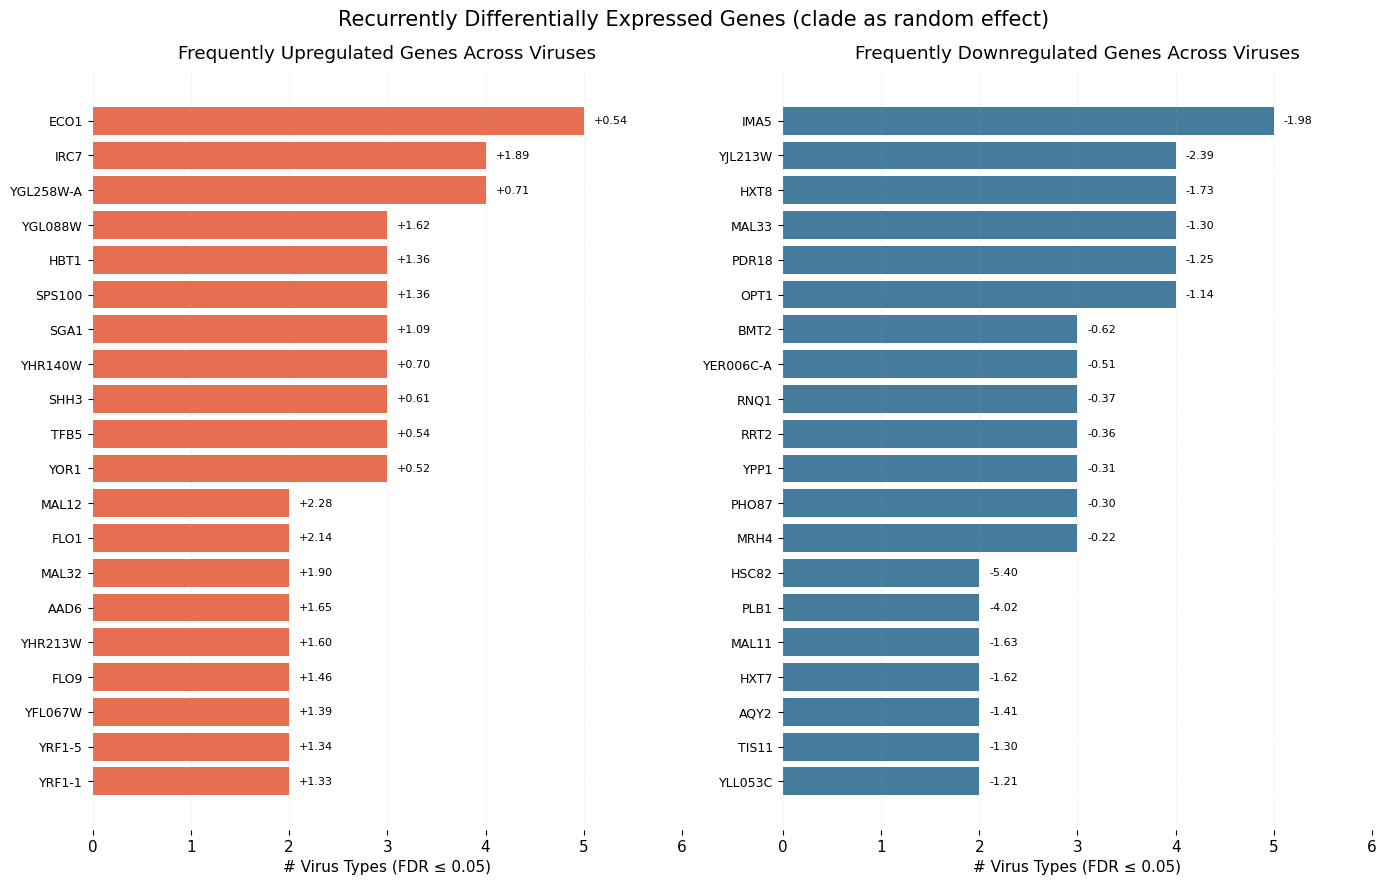


=== UPREGULATED Genes (top 20) ===
ECO1 (YFR027W): Acetyltransferase required for sister chromatid cohesion; elicits cohesin dimerization during S phase; acetylates Mps3p to regulate nuclear organization; modifies Smc3p at replication forks and Mcd1p in response to dsDNA breaks; phosphorylated by Cdc28p, Cdc7p, Mck1p to generate pair of phosphates spaced precisely for recognition by ubiquitin ligase SCF-Cdc4; relative distribution to nucleus increases upon DNA replication stress; mutations in human homolog ESCO2 cause Roberts syndrome [n_virus=5, mean_beta=+0.54]
IRC7 (YFR055W): Cysteine desulphydrase, enables growth on cysteine as nitrogen source; involved in the production of thiols; null mutant displays increased levels of spontaneous Rad52p foci; expression induced by nitrogen limitation in a GLN3, GAT1-dependent manner and by copper levels in a Mac1-dependent manner [n_virus=4, mean_beta=+1.89]
YGL258W-A (YGL258W-A): Putative protein of unknown function [n_virus=4, mean_beta=+0.7

In [359]:
from pathlib import Path
import glob, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path("data/lmm")
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")
FDR_CUTOFF = 0.05
TOP_N = 20

def load_map(path):
    if not path.exists():
        return {}
    with open(path) as f:
        obj = json.load(f)
    if isinstance(obj, dict):
        return {str(k).strip(): str(v).strip() for k, v in obj.items()}
    mapping = {}
    for row in obj if isinstance(obj, list) else []:
        keys = {k.lower(): k for k in row.keys()}
        sys_k = keys.get("sys_gene") or keys.get("systematic")
        val_k = keys.get("std_gene") or keys.get("description") or keys.get("name")
        if sys_k and val_k:
            mapping[str(row[sys_k]).strip()] = str(row[val_k]).strip()
    return mapping

sys2std = load_map(SYS2STD)
sys2desc = load_map(SYS2DESC)

records = []
for virus_dir in sorted([p for p in BASE.iterdir() if p.is_dir()]):
    if any(['_toti_' in virus_dir.name, 'scpv3_' in virus_dir.name]):
        continue
    if virus_dir.name.lower() == "any":
        continue
    genes_dir = virus_dir / "genes"
    if not genes_dir.exists():
        continue

    for fpath in glob.glob(str(genes_dir / "up_*.csv")) + glob.glob(str(genes_dir / "down_*.csv")):
        direction = "up" if "up_" in Path(fpath).name else "down"
        df = pd.read_csv(fpath)
        if "fdr" in df.columns:
            df = df[df["fdr"] <= FDR_CUTOFF]
        for _, r in df.iterrows():
            gsys = str(r["gene"]).strip()
            gstd = sys2std.get(gsys, gsys)
            gdesc = sys2desc.get(gsys, "")
            label = f"{gstd} ({gsys})"
            records.append({
                "virus": virus_dir.name,
                "gene_sys": gsys,
                "gene_std": gstd,
                "gene_desc": gdesc,
                "label": label,
                "direction": direction,
                "beta": float(r["beta"])
            })

hits = pd.DataFrame(records)

summary = (
    hits.groupby(["label","gene_sys","gene_std","gene_desc","direction"])
        .agg(n_virus=("virus","nunique"),
             mean_beta=("beta","mean"))
        .reset_index()
)

def rank_df(df, asc_for_beta):
    df = df.copy()
    df["abs_mean_beta"] = df["mean_beta"].abs()
    return df.sort_values(["n_virus","abs_mean_beta"],
                          ascending=[False, asc_for_beta]).head(TOP_N)

top_up = rank_df(summary[summary["direction"]=="up"], asc_for_beta=False)
top_down = rank_df(summary[summary["direction"]=="down"], asc_for_beta=False)

# --- Plot ---
fig, axes = plt.subplots(1,2, figsize=(14,9), sharey=False)

def plot_panel(ax, df, title, color):
    if df.empty:
        ax.set_title(title + "\n(no recurrent genes)")
        ax.axis("off")
        return
    y = np.arange(len(df))[::-1]
    ax.barh(y, df["n_virus"].to_numpy(), color=color)
    ax.set_yticks(y)
    ax.set_yticklabels(df["gene_std"].to_list(), fontsize=9)  # show standard names only
    ax.set_xlabel("# Virus Types (FDR ≤ {:.02f})".format(FDR_CUTOFF))
    ax.set_title(title, pad=10)
    for i, (cnt, mb) in enumerate(zip(df["n_virus"], df["mean_beta"])):
        ax.text(cnt + 0.1, y[i], f"{mb:+.2f}", va="center", fontsize=8)
    ax.set_xlim(0, max(df["n_virus"].max() + 1, 3))
    ax.grid(axis="x", linestyle=":", alpha=0.3)

plot_panel(axes[0], top_up, "Frequently Upregulated Genes Across Viruses", "#e76f51")
plot_panel(axes[1], top_down, "Frequently Downregulated Genes Across Viruses", "#457b9d")

fig.suptitle("Recurrently Differentially Expressed Genes (clade as random effect)", fontsize=15)
plt.tight_layout()
plt.show()

# --- Gene definitions table below ---
def print_gene_defs(df, direction):
    print(f"\n=== {direction.upper()} Genes (top {len(df)}) ===")
    for _, row in df.iterrows():
        print(f"{row['gene_std']} ({row['gene_sys']}): {row['gene_desc']} "
              f"[n_virus={row['n_virus']}, mean_beta={row['mean_beta']:+.2f}]")

print_gene_defs(top_up, "upregulated")
print_gene_defs(top_down, "downregulated")

In [282]:
# # Minimal: load recurrent hits from the 'any' folder only (no plotting)

# from pathlib import Path
# import glob, json
# import pandas as pd

# BASE = Path("data/lmm")
# ANY_DIR = BASE / "any" / "genes"
# SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
# SYS2DESC = Path("data/sys_gene_to_description_map.json")
# FDR_CUTOFF = 0.05  # change if you like

# def load_map(path):
#     if not path.exists():
#         return {}
#     with open(path) as f:
#         obj = json.load(f)
#     if isinstance(obj, dict):
#         return {str(k).strip(): str(v).strip() for k, v in obj.items()}
#     # fallback for list-of-records json
#     mapping = {}
#     for row in obj if isinstance(obj, list) else []:
#         keys = {k.lower(): k for k in row.keys()}
#         sys_k = keys.get("sys_gene") or keys.get("systematic")
#         val_k = keys.get("std_gene") or keys.get("description") or keys.get("name")
#         if sys_k and val_k:
#             mapping[str(row[sys_k]).strip()] = str(row[val_k]).strip()
#     return mapping

# sys2std  = load_map(SYS2STD)
# sys2desc = load_map(SYS2DESC)

# records = []
# if ANY_DIR.exists():
#     # accept both "up_*.csv"/"down_*.csv" and "up*.csv"/"down*.csv"
#     files = sorted(set(glob.glob(str(ANY_DIR / "up_*.csv")) +
#                        glob.glob(str(ANY_DIR / "down_*.csv")) +
#                        glob.glob(str(ANY_DIR / "up*.csv")) +
#                        glob.glob(str(ANY_DIR / "down*.csv"))))
#     for fpath in files:
#         fname = Path(fpath).name.lower()
#         direction = "up" if fname.startswith("up") else "down" if fname.startswith("down") else None
#         df = pd.read_csv(fpath)
#         if "fdr" in df.columns:
#             df = df[df["fdr"] <= FDR_CUTOFF]
#         for _, r in df.iterrows():
#             gsys  = str(r.get("gene", "")).strip()
#             if not gsys:
#                 continue
#             records.append({
#                 "virus": "ANY",
#                 "file": Path(fpath).name,
#                 "direction": direction or ("up" if float(r.get("beta", 0)) > 0 else "down"),
#                 "beta": float(r.get("beta", float("nan"))),
#                 "fdr":  float(r.get("fdr", float("nan"))),
#                 "gene_sys": gsys,
#                 "gene_std": sys2std.get(gsys, gsys),
#                 "gene_desc": sys2desc.get(gsys, "")
#             })

# hits = pd.DataFrame(records)
# hits = hits[["virus","file","direction","gene_sys","gene_std","gene_desc","beta","fdr"]]

# print(f"Loaded {len(hits)} rows from {ANY_DIR}")
# display(hits.head())
# # If you want it on disk:
# # hits.to_csv("data/lmm/any/any_hits_filtered.tsv", sep="\t", index=False)

In [360]:
# === Parse SGD GFF3 (from saccharomyces_cerevisiae_R64*.gff.gz) ===
from pathlib import Path
import pandas as pd, re, gzip

CACHE = Path("data/S288C_reference_genome_R64-5-1_20240529")
CACHE.mkdir(parents=True, exist_ok=True)
GFF = CACHE / "saccharomyces_cerevisiae_R64-5-1_20240529.gff.gz"
COORDS = CACHE / "sgd_coords.tsv"

def parse_gff3(path: Path) -> pd.DataFrame:
    colnames = ["seqid","source","type","start","end","score","strand","phase","attributes"]
    rows = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith("#"): continue
            toks = line.rstrip("\n").split("\t")
            if len(toks) != 9: continue
            rec = dict(zip(colnames, toks))
            if rec["type"] not in ["gene","ORF","pseudogene","ncRNA_gene","snoRNA_gene","snRNA_gene","tRNA_gene","rRNA_gene"]:
                continue
            attrs = {kv.split("=",1)[0]: kv.split("=",1)[1] for kv in rec["attributes"].split(";") if "=" in kv}
            rec["systematic"] = attrs.get("IDyea ","").split(":")[-1]
            rec["standard"]   = attrs.get("Name") or attrs.get("gene_name") or ""
            rows.append(rec)
    df = pd.DataFrame(rows)
    def norm_chr(x):
        m = re.search(r"chr(?:mt)?([IVXLCDM]+|M)", str(x), re.I)
        if m:
            tag = m.group(1).upper()
            return "mt" if tag=="M" else tag
        return x
    df["chr"] = df["seqid"].map(norm_chr)
    df["start"] = pd.to_numeric(df["start"], errors="coerce").astype("Int64")
    df["end"]   = pd.to_numeric(df["end"], errors="coerce").astype("Int64")
    df = df[["systematic","standard","chr","start","end","strand","type","source"]].dropna()
    return df.drop_duplicates()

if not COORDS.exists():
    coords = parse_gff3(GFF)
    coords.to_csv(COORDS, sep="\t", index=False)
else:
    coords = pd.read_csv(COORDS, sep="\t")

print("Parsed coords:", coords.shape)
coords.head()

Parsed coords: (7062, 8)


,systematic,standard,chr,start,end,strand,type,source
0,YAL069W,YAL069W,I,335,649,+,gene,SGD
1,YAL068W-A,YAL068W-A,I,538,792,+,gene,SGD
2,YAL068C,YAL068C,I,1807,2169,-,gene,SGD
3,YAL067W-A,YAL067W-A,I,2480,2707,+,gene,SGD
4,YAL067C,YAL067C,I,7013,9049,-,gene,SGD


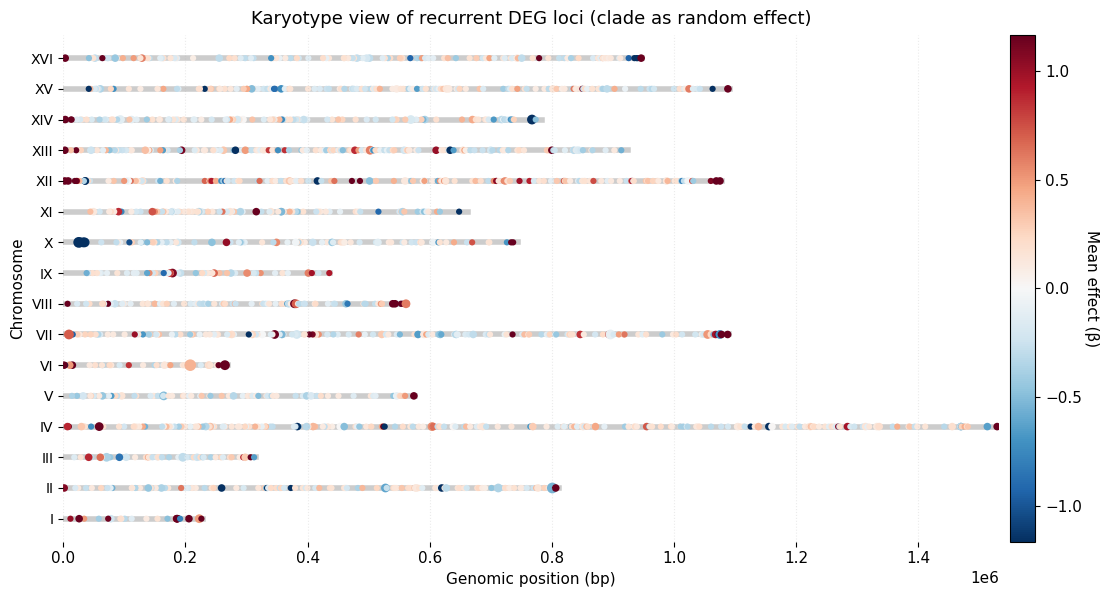

In [361]:
# === Karyotype scatter of recurrent DE genes (SGD S288C) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

COORDS_TSV = Path(COORDS)  # produced earlier
assert COORDS_TSV.exists(), "Run the SGD parsing cell first to create sgd_coords.tsv"

# 1) Collapse to one effect per gene (signed mean across viruses)
#    `hits` already contains only FDR-passing entries (your cell filtered at FDR_CUTOFF)
eff = (
    hits.groupby(["gene_sys"], as_index=False)
        .agg(mean_beta=("beta","mean"),
             n_calls=("beta","size"),
             gene_std=("gene_std","first"),
             gene_desc=("gene_desc","first"))
)

# 2) Bring in coordinates (systematic names match SGD “systematic”)
coords = pd.read_csv(COORDS_TSV, sep="\t", dtype={"systematic":str})
df = eff.merge(coords, left_on="gene_sys", right_on="systematic", how="inner")

# Midpoint position; chromosome order (I..XVI, mt at end if present)
df["mid"] = (df["start"] + df["end"]) / 2.0
chr_order = [ "I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI","mt" ]
df["chr"] = pd.Categorical(df["chr"].astype(str), categories=chr_order, ordered=True)
df = df.dropna(subset=["chr"])

# 3) Keep only chromosomes with any representation
present_chrs = [c for c in chr_order if (df["chr"]==c).any()]
df = df[df["chr"].isin(present_chrs)]

# 4) Chromosome “lengths” = max end observed in GFF (good enough for axis spans)
chr_len = coords.groupby("chr", as_index=True)["end"].max()

# 5) Color scale: symmetric by robust max |beta| (95th percentile)
robust = np.nanpercentile(np.abs(df["mean_beta"]), 95) or 1.0
vmax = float(np.clip(robust, 0.5, None))  # avoid tiny scales
vmin = -vmax

# 6) Plot
fig, ax = plt.subplots(figsize=(12, 0.5 + 0.35*len(present_chrs)))

ypos = {c:i for i,c in enumerate(present_chrs)}
ax.set_yticks(range(len(present_chrs)))
ax.set_yticklabels(present_chrs, fontsize=10)

# Chromosome backbones
for c in present_chrs:
    L = float(chr_len.get(c, df.loc[df["chr"]==c, "end"].max()))
    y = ypos[c]
    ax.plot([0, L], [y, y], color="#cccccc", lw=4, zorder=0)

# Gene points (size scaled by recurrence)
sizes = 10 + 10 * np.clip(df["n_calls"], 1, None)  # simple scaling
sc = ax.scatter(df["mid"], df["chr"].map(ypos),
                c=df["mean_beta"], s=sizes,
                cmap="RdBu_r", vmin=vmin, vmax=vmax, edgecolor="none")

ax.set_xlabel("Genomic position (bp)", fontsize=11)
ax.set_ylabel("Chromosome", fontsize=11)
ax.set_title("Karyotype view of recurrent DEG loci (clade as random effect)", fontsize=13, pad=8)

# Clean x-lims per visible chromosomes
xmin = df.groupby("chr")["mid"].min().min() * 0.0
xmax = max(chr_len.get(c, df.loc[df["chr"]==c, "end"].max()) for c in present_chrs)
ax.set_xlim(xmin, xmax)

# Legend / colorbar
cb = plt.colorbar(sc, ax=ax, pad=0.01)
cb.set_label("Mean effect (β)", rotation=270, labelpad=12)

ax.grid(axis="x", linestyle=":", alpha=0.25)
plt.tight_layout()
plt.show()

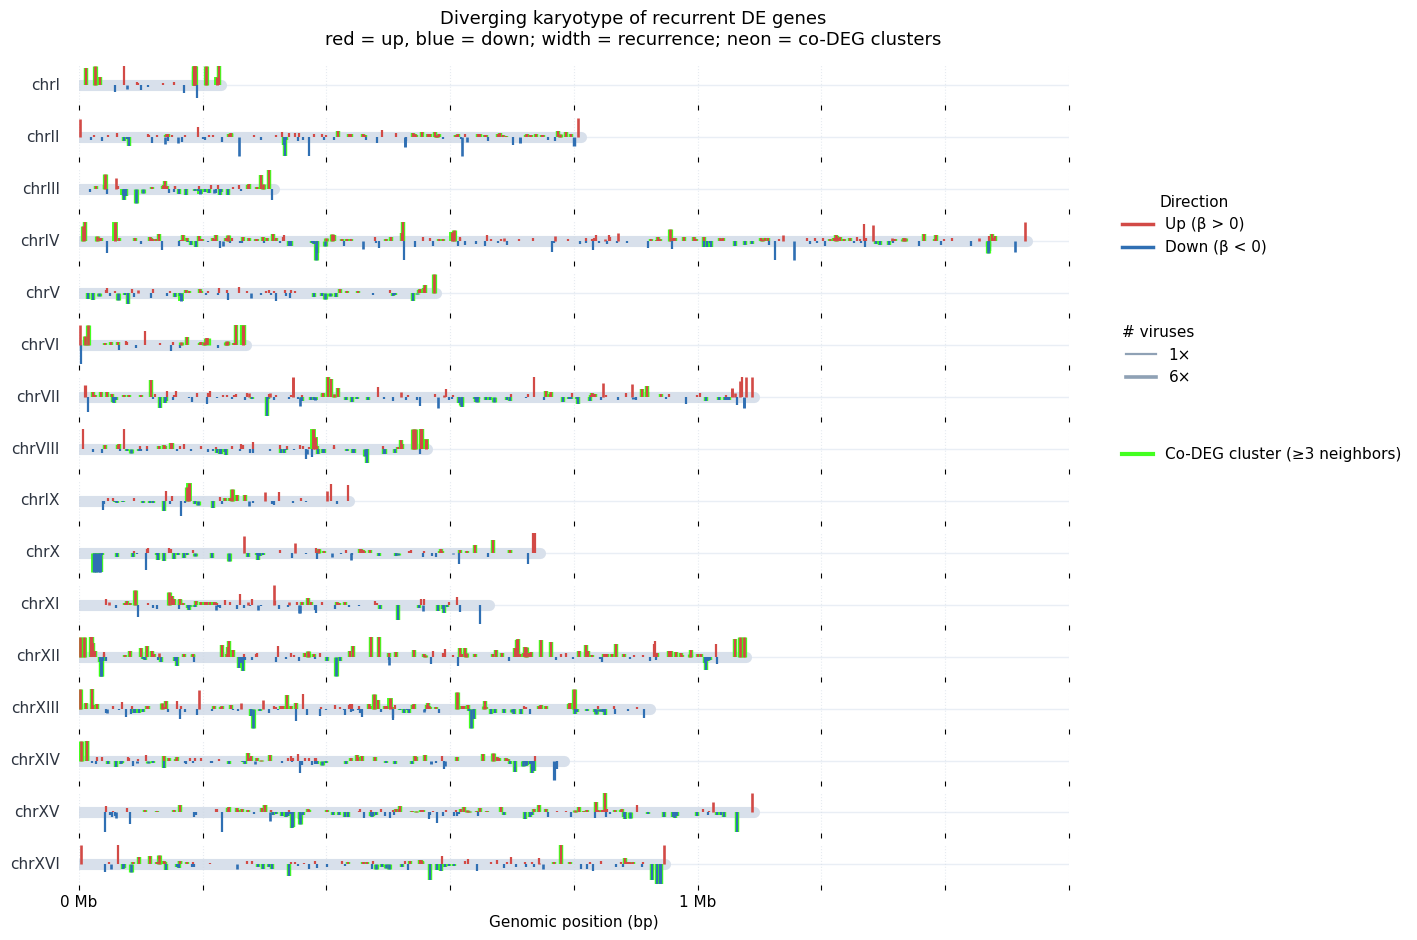

In [362]:
# --- Diverging karyotype with cluster highlighting (≥3 adjacent same-direction genes) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# collapse across viruses to one effect per gene
eff = (
    hits.groupby("gene_sys", as_index=False)
        .agg(mean_beta=("beta","mean"),
             n_calls=("beta","size"),
             gene_std=("gene_std","first"),
             gene_desc=("gene_desc","first"))
)

# join SGD coordinates
df = eff.merge(
    coords[["systematic","chr","start","end"]],
    left_on="gene_sys", right_on="systematic", how="inner"
)
df["mid"] = (df["start"] + df["end"]) / 2.0
df["chr"] = df["chr"].astype(str)

# chromosome order
order = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI","mt"]
present = [c for c in order if (df["chr"] == c).any()]
df = df[df["chr"].isin(present)].copy()
df["chr"] = pd.Categorical(df["chr"], categories=present, ordered=True)

# per-chromosome lengths & global x-scale
chr_len = coords.groupby("chr")["end"].max().reindex(present).astype(float)
Lmax = float(chr_len.max())

# robust symmetric β scale
robust = np.nanpercentile(np.abs(df["mean_beta"]), 95)
ymax = max(robust, 0.8)
df["beta_clip"] = df["mean_beta"].clip(-ymax, ymax)
df["sign"] = np.sign(df["beta_clip"]).astype(int)  # -1, 0, +1 (0 will be treated as no bar)

# flag cluster membership: within a run of ≥3 adjacent genes with identical sign on the same chr
df["cluster"] = False
cluster_min_run = 3
cluster_span_bp = None  # set e.g. 20_000 to also require proximity; None = adjacency only

for chrom in present:
    idx = df.index[df["chr"] == chrom]
    if idx.empty:
        continue
    # order by genomic position
    idx = idx[np.argsort(df.loc[idx, "mid"].to_numpy())]
    signs = df.loc[idx, "sign"].to_numpy()
    mids  = df.loc[idx, "mid"].to_numpy()

    # identify runs
    run_start = 0
    for i in range(1, len(idx)+1):
        at_break = (i == len(idx)) or (signs[i] != signs[i-1]) or (signs[i] == 0)
        if not at_break:
            continue
        # run is [run_start, i-1]
        run_len = i - run_start
        if signs[i-1] != 0 and run_len >= cluster_min_run:
            # optional proximity constraint
            if cluster_span_bp is None or (mids[i-1] - mids[run_start] <= cluster_span_bp):
                df.loc[idx[run_start:i], "cluster"] = True
        run_start = i

# styles
c_up, c_down = "#D24A46", "#2F6FB3"       # bar colors
c_cluster = "#39FF14"                     # neon green highlight
row_guide = "#e9eef5"                     # faint solid row guide
backbone = "#D8E0EB"                      # chromosome backbone
backbone_lw = 8                           # round-capped line width (pixels)
halo_gain = 2.0                           # cluster halo thickness multiplier

def lw_from_calls(n, base=0.9, gain=0.7):
    return base + gain * np.sqrt(max(int(n), 1))

plt.rcParams.update({
    "font.size": 11,
    "axes.spines.left": False, "axes.spines.right": False,
    "axes.spines.top": False,  "axes.spines.bottom": False,
})

row_h = 0.55
fig_h = max(4.0, 1.2 + row_h*len(present))
fig, axes = plt.subplots(
    len(present), 1, figsize=(13.2, fig_h),
    sharex=True,
    gridspec_kw={"left":0.08, "right":0.83, "top":0.92, "bottom":0.10, "hspace":0.28}
)
axes = [axes] if len(present)==1 else list(axes)

for ax, chrom in zip(axes, present):
    sub = df[df["chr"] == chrom]
    L   = float(chr_len.loc[chrom])

    # faint row guide
    ax.axhline(0, color=row_guide, lw=1.0, zorder=0)

    # chromosome backbone as a round-capped thick line
    ax.plot([0, L], [0, 0], color=backbone, lw=backbone_lw, solid_capstyle="round", zorder=1)

    # draw bars (neon halo first if in cluster, then colored bar)
    for _, r in sub.iterrows():
        x, b, n = float(np.clip(r["mid"], 0, L)), float(r["beta_clip"]), int(r["n_calls"])
        if b == 0 or np.isnan(b):  # nothing to draw
            continue
        lw = lw_from_calls(n)
        if r["cluster"]:
            ax.vlines(x, 0, b, color=c_cluster, lw=lw*halo_gain, zorder=3, alpha=0.95)
        ax.vlines(x, 0, b, color=(c_up if b > 0 else c_down), lw=lw, zorder=4)

    # row cosmetics
    ax.set_xlim(0, Lmax)
    ax.set_ylim(-ymax*1.05, ymax*1.05)
    ax.set_yticks([])
    ax.grid(axis="x", linestyle=":", color="#cfd8e3", alpha=0.5)
    # chromosome label
    ax.text(-0.02*Lmax, 0, f"chr{chrom}", ha="right", va="center", color="#2d3440")

# bottom ticks in Mb
ticks = np.arange(0, Lmax+200_000, 200_000)
axes[-1].set_xticks(ticks)
axes[-1].set_xticklabels([f"{int(t/1e6)} Mb" if t%1_000_000==0 else "" for t in ticks])
axes[-1].set_xlabel("Genomic position (bp)")

# legends
dir_handles = [
    Line2D([0],[0], color=c_up,   lw=2.5, label="Up (β > 0)"),
    Line2D([0],[0], color=c_down, lw=2.5, label="Down (β < 0)")
]
levels = sorted({int(df["n_calls"].min()), int(np.median(df["n_calls"])), int(df["n_calls"].max())})
levels = [l for l in levels if l>0][:3] or [1,2,3]
rec_handles = [Line2D([0],[0], color="#8fa1b5", lw=lw_from_calls(n), label=f"{n}×") for n in levels]
cluster_handle = Line2D([0],[0], color=c_cluster, lw=3.0, label="Co-DEG cluster (≥3 neighbors)", alpha=0.95)

fig.legend(dir_handles, [h.get_label() for h in dir_handles],
           loc="center left", bbox_to_anchor=(0.86, 0.76), frameon=False, title="Direction")
fig.legend(rec_handles, [h.get_label() for h in rec_handles],
           loc="center left", bbox_to_anchor=(0.86, 0.63), frameon=False, title="# viruses")
fig.legend([cluster_handle], [cluster_handle.get_label()],
           loc="center left", bbox_to_anchor=(0.86, 0.53), frameon=False)

fig.suptitle("Diverging karyotype of recurrent DE genes\n"
             "red = up, blue = down; width = recurrence; neon = co-DEG clusters",
             fontsize=13, y=0.975)
plt.show()

Observed same-direction adjacent pairs: 884
Observed runs (length ≥ 3):        214

Empirical p (adjacent same-dir pairs): 0.001996
Empirical p (runs ≥ 3):          0.001996


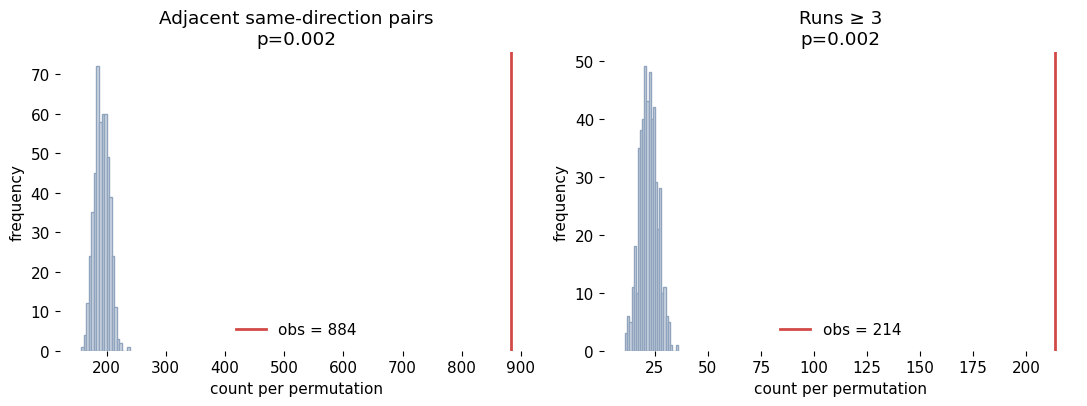

In [236]:
# === Permutation test for adjacency / run enrichment of DEGs ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
rng = np.random.default_rng(12345)

# ---------- INPUTS ----------
# Use the same dataframe you used for the karyotype plot:
# df must have columns: 'chr', 'systematic' (gene id), 'mid' (bp position), and an effect size.
work = df.copy()
work["sign"] = np.sign(work["mean_beta"]).astype(int) if "mean_beta" in work.columns else np.sign(work["beta_clip"]).astype(int)

# Keep one row per gene per chrom and order by position
work = (work[["chr","systematic","mid","sign"]]
        .drop_duplicates(subset=["chr","systematic"])
        .sort_values(["chr","mid"])
        .reset_index(drop=True))

# Optional: only count “protein-coding like” features by constraining the candidate universe to SGD coords types
# Here we just use all genes in coords per chromosome as the placement universe.
universe = (coords[["chr","systematic","start","end","type"]]
            .drop_duplicates(subset=["chr","systematic"])
            .sort_values(["chr","start"])
            .rename(columns={"start":"mid"}))
universe["mid"] = (universe["mid"].astype(float) + universe["end"].astype(float)) / 2.0

# how we score clustering
RUN_K = 3                 # run length threshold (≥k genes with same direction)
N_PERM = 500             # permutations (bump to 50k later if you want tighter p-values)
DIST_MAX = None           # optional: max bp gap to still count as adjacent (e.g. 20_000). None = purely next neighbor in order

def adjacency_counts(df_chr, dist_max=None):
    """Return (same_dir_pairs, runs_ge_k) for a single-chromosome ordered frame with a 'sign' column."""
    s = df_chr["sign"].to_numpy()
    x = df_chr["mid"].to_numpy()
    # same-direction adjacent pairs
    same = (s[:-1] != 0) & (s[1:] != 0) & (s[1:] == s[:-1])
    if dist_max is not None:
        same &= (np.diff(x) <= dist_max)
    same_pairs = int(same.sum())
    # runs ≥ RUN_K
    runs = 0
    i = 0
    while i < len(s):
        if s[i] == 0:
            i += 1
            continue
        j = i + 1
        # extend while same direction and (optionally) close enough
        while j < len(s) and s[j] == s[i] and (dist_max is None or (x[j] - x[j-1] <= dist_max)):
            j += 1
        run_len = j - i
        if run_len >= RUN_K:
            runs += 1
        i = j
    return same_pairs, runs

# ---------- observed statistics ----------
obs_pairs = 0
obs_runs  = 0
per_chr_counts = {}  # for constrained permutations
for chrom, sub in work.groupby("chr", sort=False):
    sub = sub.sort_values("mid")
    p, r = adjacency_counts(sub, dist_max=DIST_MAX)
    obs_pairs += p
    obs_runs  += r
    # record how many up/down we observed on this chromosome
    n_up   = int((sub["sign"] ==  1).sum())
    n_down = int((sub["sign"] == -1).sum())
    per_chr_counts[chrom] = (n_up, n_down)

print(f"Observed same-direction adjacent pairs: {obs_pairs}")
print(f"Observed runs (length ≥ {RUN_K}):        {obs_runs}")

# ---------- permutations under a stratified null ----------
def perm_once():
    pairs = 0
    runs  = 0
    for chrom, (n_up, n_down) in per_chr_counts.items():
        cand = universe[universe["chr"] == chrom]
        if cand.empty:
            continue
        n = len(cand)
        # choose positions for up & down without overlap
        # if observed counts exceed available positions (shouldn't), cap them
        nu = min(n_up, n)
        nd = min(n_down, n - nu)
        idx = rng.choice(n, size=nu+nd, replace=False)
        rng.shuffle(idx)
        idx_up, idx_down = idx[:nu], idx[nu:nu+nd]
        sign = np.zeros(n, dtype=int)
        sign[idx_up] =  1
        sign[idx_down] = -1
        tmp = cand[["chr","mid"]].copy().reset_index(drop=True)
        tmp["sign"] = sign
        tmp = tmp.sort_values("mid")
        p, r = adjacency_counts(tmp, dist_max=DIST_MAX)
        pairs += p
        runs  += r
    return pairs, runs

null_pairs = np.empty(N_PERM, dtype=int)
null_runs  = np.empty(N_PERM, dtype=int)
for i in range(N_PERM):
    p, r = perm_once()
    null_pairs[i] = p
    null_runs[i]  = r

# empirical p-values (right-tailed; more clustering than null)
p_pairs = (np.sum(null_pairs >= obs_pairs) + 1) / (N_PERM + 1)
p_runs  = (np.sum(null_runs  >= obs_runs ) + 1) / (N_PERM + 1)
print(f"\nEmpirical p (adjacent same-dir pairs): {p_pairs:.4g}")
print(f"Empirical p (runs ≥ {RUN_K}):          {p_runs:.4g}")

# ---------- quick plots ----------
fig, axs = plt.subplots(1,2, figsize=(11,4.2))
axs[0].hist(null_pairs, bins="auto", color="#cfd8e3", edgecolor="#90a4be")
axs[0].axvline(obs_pairs, color="#d24a46", lw=2, label=f"obs = {obs_pairs}")
axs[0].set_title(f"Adjacent same-direction pairs\np={p_pairs:.3g}")
axs[0].set_xlabel("count per permutation"); axs[0].set_ylabel("frequency")
axs[0].legend(frameon=False)

axs[1].hist(null_runs, bins=range(null_runs.min(), null_runs.max()+2), color="#cfd8e3", edgecolor="#90a4be")
axs[1].axvline(obs_runs, color="#d24a46", lw=2, label=f"obs = {obs_runs}")
axs[1].set_title(f"Runs ≥ {RUN_K}\np={p_runs:.3g}")
axs[1].set_xlabel("count per permutation"); axs[1].set_ylabel("frequency")
axs[1].legend(frameon=False)

plt.tight_layout()
plt.show()

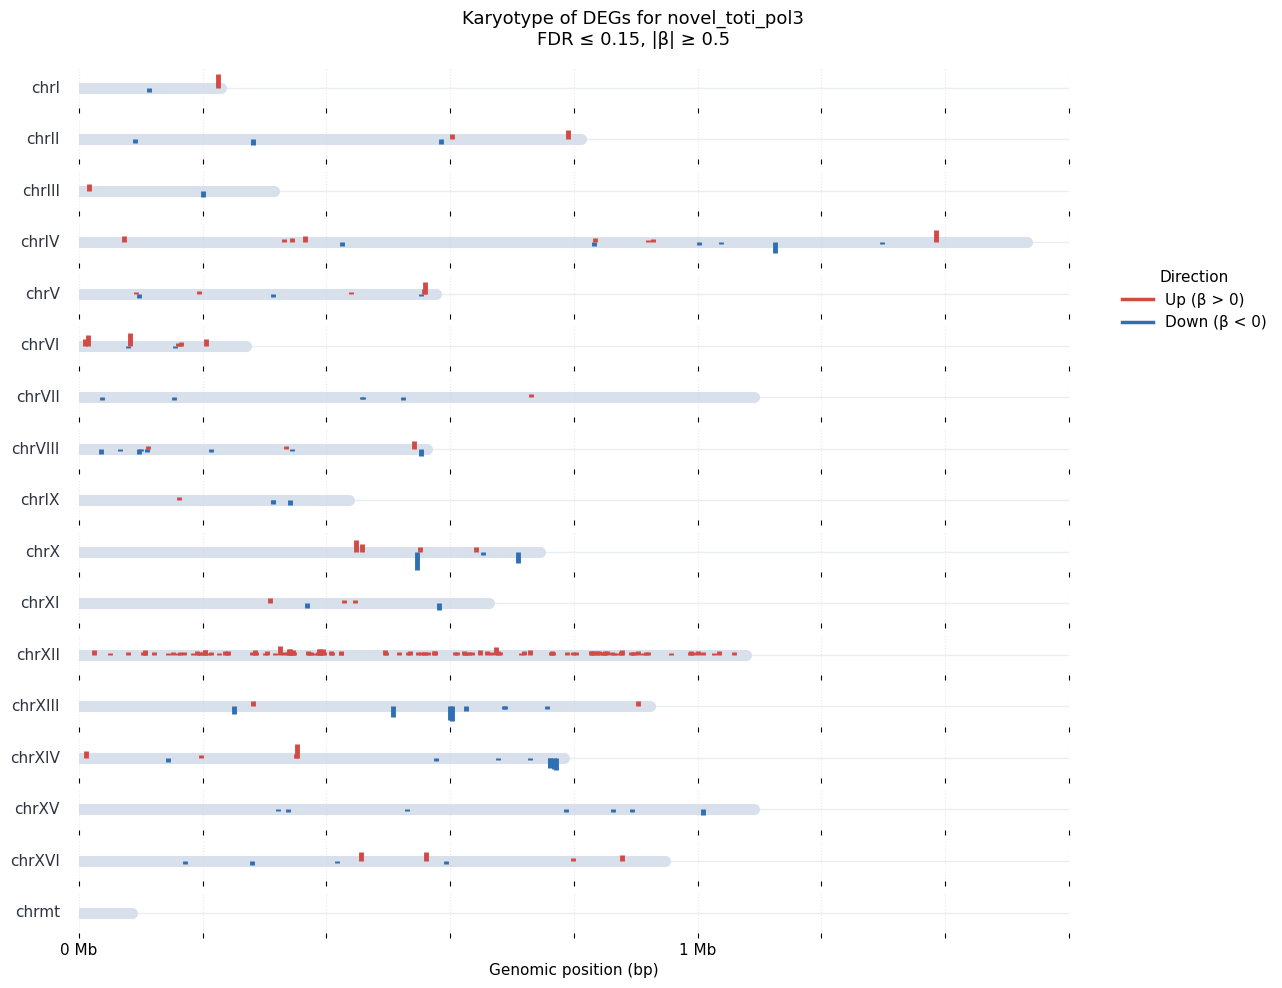

In [363]:
def plot_karyotype_for_virus(
    virus_name: str,
    fdr_cutoff: float = 0.05,
    min_abs_beta: float = 0.0,
):
    virus_dir = BASE / virus_name
    genes_dir = virus_dir / "genes"
    if not genes_dir.exists():
        print(f"[!] Gene directory not found: {genes_dir}")
        return

    # Load DEGs
    records = []
    for fpath in sorted(glob.glob(str(genes_dir / "up_*.csv")) + glob.glob(str(genes_dir / "down_*.csv"))):
        direction = "up" if "up_" in Path(fpath).name else "down"
        df = pd.read_csv(fpath)
        if "fdr" in df.columns:
            df = df[df["fdr"] <= fdr_cutoff]
        for _, r in df.iterrows():
            beta = float(r["beta"])
            if abs(beta) < min_abs_beta:
                continue
            gsys = str(r["gene"]).strip()
            gstd = sys2std.get(gsys, gsys)
            gdesc = sys2desc.get(gsys, "")
            records.append({
                "gene_sys": gsys,
                "gene_std": gstd,
                "gene_desc": gdesc,
                "direction": direction,
                "beta": beta
            })

    if not records:
        print(f"[!] No DEGs passed filters for: {virus_name}")
        return

    df = pd.DataFrame(records)

    # Join with coordinates
    df = df.merge(
        coords[["systematic", "chr", "start", "end"]],
        left_on="gene_sys", right_on="systematic", how="inner"
    )

    df["mid"] = (df["start"] + df["end"]) / 2.0
    df["chr"] = df["chr"].astype(str)

    # Chromosome setup
    order = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII",
             "IX", "X", "XI", "XII", "XIII", "XIV", "XV", "XVI", "mt"]

    chr_len = coords.groupby("chr")["end"].max().reindex(order).astype(float)
    present = chr_len[chr_len.notna()].index.tolist()

    df = df[df["chr"].isin(present)].copy()
    df["chr"] = pd.Categorical(df["chr"], categories=present, ordered=True)
    Lmax = float(chr_len.max())

    # Determine plotting scale based on full β range
    ymax = max(np.ceil(df["beta"].abs().max()), 1.0)

    # --- Plot styles ---
    c_up, c_down = "#D24A46", "#2F6FB3"
    row_guide = "#e9eef5"
    backbone = "#D8E0EB"
    backbone_lw = 8
    fixed_lw = 3.5

    plt.rcParams.update({
        "font.size": 11,
        "axes.spines.left": False, "axes.spines.right": False,
        "axes.spines.top": False,  "axes.spines.bottom": False,
    })

    row_h = 0.55
    fig_h = max(4.0, 1.2 + row_h * len(present))
    fig, axes = plt.subplots(
        len(present), 1, figsize=(13.2, fig_h),
        sharex=True,
        gridspec_kw={"left": 0.08, "right": 0.83, "top": 0.92, "bottom": 0.10, "hspace": 0.28}
    )
    axes = [axes] if len(present) == 1 else list(axes)

    for ax, chrom in zip(axes, present):
        sub = df[df["chr"] == chrom]
        L = float(chr_len.loc[chrom])

        ax.axhline(0, color=row_guide, lw=1.0, zorder=0)
        ax.plot([0, L], [0, 0], color=backbone, lw=backbone_lw,
                solid_capstyle="round", zorder=1)

        if not sub.empty:
            for _, r in sub.iterrows():
                x = float(np.clip(r["mid"], 0, L))
                b = float(r["beta"])
                color = c_up if b > 0 else c_down
                ax.vlines(x, 0, b, color=color, lw=fixed_lw, zorder=3)

        ax.set_xlim(0, Lmax)
        ax.set_ylim(-ymax * 1.05, ymax * 1.05)
        ax.set_yticks([])
        ax.grid(axis="x", linestyle=":", color="#cfd8e3", alpha=0.5)
        ax.text(-0.02 * Lmax, 0, f"chr{chrom}", ha="right", va="center", color="#2d3440")

    ticks = np.arange(0, Lmax + 200_000, 200_000)
    axes[-1].set_xticks(ticks)
    axes[-1].set_xticklabels([f"{int(t/1e6)} Mb" if t % 1_000_000 == 0 else "" for t in ticks])
    axes[-1].set_xlabel("Genomic position (bp)")

    dir_handles = [
        Line2D([0], [0], color=c_up, lw=2.5, label="Up (β > 0)"),
        Line2D([0], [0], color=c_down, lw=2.5, label="Down (β < 0)")
    ]

    fig.legend(dir_handles, [h.get_label() for h in dir_handles],
               loc="center left", bbox_to_anchor=(0.86, 0.70), frameon=False, title="Direction")

    fig.suptitle(f"Karyotype of DEGs for {virus_name}\n"
                 f"FDR ≤ {fdr_cutoff}, |β| ≥ {min_abs_beta}",
                 fontsize=13, y=0.975)
    plt.show()
    
    
plot_karyotype_for_virus("novel_toti_pol3", fdr_cutoff=0.15, min_abs_beta=0.5)

In [412]:
# virus_dirnames = iter(sorted([p.name for p in BASE.iterdir() if p.is_dir()]))

plot_karyotype_for_virus(next(virus_dirnames), fdr_cutoff=0.15, min_abs_beta=0.5)

StopIteration: 